# Evaluation of Pre-Trained Object Detection Models for on Data for different Driving Condititions

**Authors:** Kevin Okiah,  Ramesh Simhambhatla, Shravan  Kuchkula,

**Date:** 01/03/2019

**Organization:** DataScience@SMU Capstone



**Abstract:** Transfer learning (to be updated)

**References:** 
1. The code is adopted and modified from tensorflow modelzoo link  below https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
2. **Dataset:**

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pandas as pd
from PIL import Image
import cv2
import pandas as pd
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import time

import os


#!pip install unipath

from unipath import Path

ObjectDetectionDirPath = Path(os.getcwd())

ResearchFolderPath = Path(ObjectDetectionDirPath.parent).parent # this id need to import object detection utils below if not working from its directory
#sys.path.append("..")  # This is needed since the notebook is stored in the object_detection folder.
sys.path.append(ResearchFolderPath)  # update this to tensorflow research directory

from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


In [2]:
# This is needed to display the images.
%matplotlib inline

In [3]:
### check if GPU exists

In [4]:
from tensorflow.python.client import device_lib

In [5]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11735322607060619123, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2474115072
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15796802390490992976
 physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [6]:
#from utils import label_map_util
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [7]:
# What model to download.
#https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
myModels = ['faster_rcnn_inception_v2_coco_custom'
            ,'faster_rcnn_inception_v2_coco','faster_rcnn_resnet50_coco','ssd_inception_v2_coco','rfcn_resnet101_coco', 
            'mask_rcnn_inception_v2_coco']#,'mask_rcnn_resnet101_atrous_coco'] #'faster_rcnn_inception_v2_coco',
#myModels =[]
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(ObjectDetectionDirPath.parent, 'data/mscoco_label_map.pbtxt')

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Dowload and load frozen model
def Download_and_loadFrozen_model(current_model = myModels[0]):
    MODEL_NAME = current_model+'_2018_01_28'
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

    # Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

    #download model
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
      file_name = os.path.basename(file.name)
      if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())
    print(current_model + " model has been downloaded...") 

def LoadFrozenModel(current_model = myModels[0]):
    MODEL_NAME = current_model+'_2018_01_28'
    # Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
    #load frozen model
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    #print(current_model+" model loaded...")
    return detection_graph
    



In [8]:
coco_labels = pd.DataFrame(category_index).T

coco_labels.to_csv("coco_object_labels.csv")

In [9]:
# Commect this section out if you want to download models passed from the Download_and_loadFrozen_model list above
#for i in myModels:
#    #download and load a frozen model
#    detection_graph =Download_and_loadFrozen_model(i) #You can pass model name here

### Inference and  Object Detection

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    #############################################
    # Comment this code out if you don't have a GPU
    #############################################
    #with tf.device('/device:GPU:0'):
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [12]:
import os
# Size, in inches, of the output images.
IMAGE_SIZE = (20, 10)

In [13]:
def InferNowXXX(modelName =myModels[0], detection_graph=LoadFrozenModel(), size=300):
    Temp = pd.DataFrame()
    dataX = pd.DataFrame()
    result = pd.DataFrame()
    targetfolder ='images/images'+str(size)+'/Val'
    #folders = ['samples-1k/Driving_condition/day/','samples-1k/Driving_condition/night', 'samples-1k/Driving_condition/Snowy']
    #condition = ['dayX']#, 'Night', 'Snowy']
    for i in range(0,len(folders)):
        Imageslist = os.listdir(folders[i]+targetfolder )
        Imageslist.sort()

        PATH_TO_TEST_IMAGES_DIR =folders[i]+targetfolder 
        imagePATH = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, Imageslist[j]) for j in range(0,len(Imageslist)) ]

        for image_path in imagePATH:

            image = Image.open(image_path)
            width, height = image.size
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0) 
            # Actual detection.
            t0 = time.time()
            output_dict =run_inference_for_single_image(image_np, detection_graph)
            t1 = time.time()
            total = t1-t0
            t0 =t1=0
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
               image_np,
               output_dict['detection_boxes'],
               output_dict['detection_classes'],
               output_dict['detection_scores'],
               category_index,
               instance_masks=output_dict.get('detection_masks'),
               use_normalized_coordinates=True, #
               line_thickness=2)
            #plt.figure(figsize=IMAGE_SIZE)
            #plt.imshow(image_np)
            #plt.title(modelName)
            #df = pd.DataFrame([[modelName, total, condition[i], image_path]], columns=['Model','Inference Time (Sec)','Driving Condition', 'ImageID'])
            
            print(image_path.split('/')[6], ": ", modelName, ":", round(total, 3), "Seconds")
            #print(output_dict['detection_classes'],output_dict['detection_scores'])
            detection_classes = pd.DataFrame(output_dict['detection_classes'])
            detection_scores = pd.DataFrame(output_dict['detection_scores'])
            detection_boxes  = pd.DataFrame(output_dict['detection_boxes'])
            #<class_name> <confidence> <left> <top> <right> <bottom>
            #dataX["Class"] = detection_classes
            #pd.concat([df1, df3], join="inner")
            result = pd.concat([detection_classes, detection_scores], axis=1, sort=False)
            result = pd.concat([result, detection_boxes], axis=1, sort=False)
            #the code below was the bug
            result.columns = ['Class', 'Confidence','top', 'left', 'bottom', 'right'] #updated
            result['Width'] =width
            result['Height'] =height
            result['Model']= modelName
            result['Inference Time (Sec)']= total
            result['Driving Condition'] = condition[i]
            result['ImageID'] = image_path.split('/')[6]
            result['ImageWidth'] = size
            #print(image_path.split('/'))
            Temp = Temp.append(result)
            #print(str(output_dict))
    return(Temp)

In [14]:
def Run_inference(size=300):
    temp = pd.DataFrame()
    for i in myModels:
        print("**********************************************************")
        print("*   Inferring with...: ", i,'   *')
        print("**********************************************************")
        detgraph = LoadFrozenModel(i)
        #detection_graph =Download_and_loadFrozen_model(i) #You can pass model name here
        temp = temp.append(InferNowXXX(i, detgraph, size))
        #InferNow(i, detgraph)
    print("******************************************")
    temp = temp[temp.Confidence != 0]
    temp.to_csv('InferenceData_'+str(size)+'_scaled.csv', index=False)
    #temp = pd.read_csv('InferenceData_scaled.csv')
#Run_inference()

## Generate Predict Labels txt files

In [15]:
# Generate predicted labels. txt file
# https://github.com/Cartucho/mAP#create-the-ground-truth-files
# This Code block generates predictions files which take the format below for indivisual images. 
# <class_name> <confidence> <left> <top> <right> <bottom>

def PredictionsFiles(size =300):
    temp = pd.DataFrame()
    temp = pd.read_csv('InferenceData_'+str(size)+'_scaled.csv')
    #temp = tempX[tempX.Confidence != 0]
    models = pd.unique(temp['Model'])
    Drivingcondition = pd.unique(temp['Driving Condition'])
    col_list = ['Class', 'Confidence', 'left', 'top', 'right', 'bottom'] # updated

    for i in models:
        ModelData = temp[temp['Model']==i]  #subset data by model
        #display(ModelData)
        for j in Drivingcondition:
            #print(j)
            DrivingConditionData = ModelData[ModelData['Driving Condition']==j] #subset data by driving conditon
            #print(DrivingConditionData.shape)
            templist =pd.unique(DrivingConditionData['ImageID'])
            #print(len(templist))
            for k in templist:
                ImageData = DrivingConditionData[DrivingConditionData['ImageID']==k]

                mod=list(pd.unique(ImageData.Model))[0]# model
                weather =list(pd.unique(ImageData['Driving Condition']))[0]#driving Condition
                #weather = "Day1"
                pic = list(pd.unique(ImageData.ImageID))[0].split('.')[0] #image
                directory ="samples-1k/Driving_condition/"+weather+"/images/images"+str(size)+"/predicted/"+mod+"/"
                #create the directory if it doesn't exist
                import os, errno
                try:
                    os.makedirs(directory)
                except OSError as e:
                    if e.errno != errno.EEXIST:
                        raise
                #save_address ="/sample-1k/Driving_condition/Predictions/"+mod+"/"+weather+"/"+pic+".txt" #prediction file
                ImageData[col_list].to_csv(directory+pic+".txt", header=None, index=None, sep=' ')

## Generate Groundtruth Files

In [16]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [17]:
# this function takes in folder with ground truth xml files and returns the data in a dataframe
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    classes = pd.read_csv('coco_object_labels.csv')
    classid =[]
    # add class id from the coco labels
    for i in list(xml_df['class']):
        #print([int(classes[classes.name==i].id))
        temp = [int(classes[classes.name==i].id)]
        #print(temp)
        classid =classid+temp

    xml_df['id'] =classid 
    #print(pd.unique(list(xml_df['class'])))
    # scaling the x and y coordinates for the ground truth file by the image dimensions
    xml_df["xmin_scaled"] = xml_df.xmin/xml_df.width
    xml_df["ymin_scaled"] = xml_df.ymin/xml_df.height
    xml_df["xmax_scaled"] = xml_df.xmax/xml_df.width
    xml_df["ymax_scaled"] = xml_df.ymax/xml_df.height
    return xml_df

#image_path = os.path.join(os.getcwd(), folders[0]+'/ground-truth-xml')
#GroundTruth = xml_to_csv(image_path)

In [18]:
#GroundTruth

In [19]:
# https://github.com/Cartucho/mAP#create-the-ground-truth-files
# This Code block generates predictions files which take the format below for indivisual images. 
# <class_name> <confidence> <left> <top> <right> <bottom>

def GroundTruth2txt(GroundTruth,folder= "samples-1k/Driving_condition/day", size=300):
    directory = folder+'/images/images'+str(size)+'/ground-truth/'
    temp = pd.DataFrame(GroundTruth.copy())
    #temp = tempX[tempX.Confidence != 0]
    imageslist = pd.unique(temp['filename']) #unique images
    col_list = ['id', 'xmin_scaled', 'ymin_scaled','xmax_scaled','ymax_scaled'] # updated
    print(directory)

    for i in imageslist:
        imageData = temp[temp['filename']==i]  #subset data by image
        x = i.split('.jpg')
        if len(x)>1:
            filename = i.split('.jpg')[0]+'.txt' #get the ground truth filename
        else:
            filename = i.split('.JPG')[0]+'.txt' #get the ground truth filename   
        
        import os, errno
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
        imageData[col_list].to_csv(directory+filename, header=None, index=None, sep=' ')

In [20]:
###################################################################
# This is the main function. runs all the functions in notebook   #
###################################################################

folders = ['samples-1k/Driving_condition/day/','samples-1k/Driving_condition/rainy/','samples-1k/Driving_condition/night/','samples-1k/Driving_condition/snowy/']
condition =['day','rainy','night', 'snowy'] 
imagesizes = [150,300, 450, 600]

def main(folder =folders[0]):
    for size in imagesizes:
        print(size)
        Run_inference(size)# Run Inferrence
        PredictionsFiles(size)
        #image_path = os.path.join(os.getcwd(), folder+'/ground-truth-xml')
        #GroundTruth = xml_to_csv(image_path)
        ##foldername = str(folder.split('/')[2])
        GroundTruth = pd.read_csv(folder+'images/images'+str(size)+'/val_labels.csv')
        #GroundTruth.to_csv(folder+'/'+foldername+'_groundTruthlabels.csv', index=None)
        #print('Successfully converted groundtruth xml to txt. You are ready to run mAP')
        #print(folder+'/'+foldername+'_groundTruthlabels.csv')
        GroundTruth2txt(GroundTruth, folder, size) #

########################    
for i in folders:
    main(i)
    print('############# Completed Processing   ##############: ' , i)

150
**********************************************************
*   Inferring with...:  faster_rcnn_inception_v2_coco_custom    *
**********************************************************
000000154000_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 2.671 Seconds
000000565391_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.902 Seconds
Dayvideo1_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.903 Seconds
Dayvideo1_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.352 Seconds
Dayvideo1_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.324 Seconds
Dayvideo1_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.297 Seconds
Dayvideo1_carrolton5_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.326 Seconds
Dayvideo2_carrolton0_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.295 Seconds
Dayvideo2_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.298 Seconds
Dayvideo3_carrolton10_reS

Dayvideo2_carrolton0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.242 Seconds
Dayvideo2_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.228 Seconds
Dayvideo3_carrolton10_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.23 Seconds
Dayvideo3_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.264 Seconds
Dayvideo3_carrolton15_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.242 Seconds
Dayvideo4_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.227 Seconds
Dayvideo4_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.307 Seconds
Dayvideo4_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.319 Seconds
Dayvideo4_carrolton4_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.229 Seconds
Dayvideo4_carrolton7_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.216 Seconds
Dayvideo5_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.225 Seconds
Dayvideo5_carrolton4_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.212 Seconds
Dayvideo5_ca

IMG_5881_19_reSized.jpg :  faster_rcnn_resnet50_coco : 3.799 Seconds
IMG_5881_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.814 Seconds
IMG_5885_19_reSized.jpg :  faster_rcnn_resnet50_coco : 3.86 Seconds
IMG_5886_0_reSized.jpg :  faster_rcnn_resnet50_coco : 3.821 Seconds
IMG_5886_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.834 Seconds
IMG_5891_0_reSized.jpg :  faster_rcnn_resnet50_coco : 3.878 Seconds
IMG_5896_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.88 Seconds
IMG_5896_76_reSized.jpg :  faster_rcnn_resnet50_coco : 3.809 Seconds
IMG_6032_114_reSized.jpg :  faster_rcnn_resnet50_coco : 3.855 Seconds
IMG_6032_190_reSized.jpg :  faster_rcnn_resnet50_coco : 3.829 Seconds
IMG_6032_19_reSized.jpg :  faster_rcnn_resnet50_coco : 3.857 Seconds
IMG_6032_266_reSized.jpg :  faster_rcnn_resnet50_coco : 3.841 Seconds
IMG_6032_323_reSized.jpg :  faster_rcnn_resnet50_coco : 3.841 Seconds
IMG_6032_418_reSized.jpg :  faster_rcnn_resnet50_coco : 3.835 Seconds
IMG_6032_475_reSized.jpg :  faste

IMG_6149_399_reSized.jpg :  ssd_inception_v2_coco : 2.593 Seconds
IMG_6149_627_reSized.jpg :  ssd_inception_v2_coco : 2.66 Seconds
IMG_6150_152_reSized.jpg :  ssd_inception_v2_coco : 2.638 Seconds
IMG_6150_304_reSized.jpg :  ssd_inception_v2_coco : 2.618 Seconds
IMG_6153_152_reSized.jpg :  ssd_inception_v2_coco : 2.618 Seconds
IMG_6153_38_reSized.jpg :  ssd_inception_v2_coco : 2.61 Seconds
IMG_6154_190_reSized.jpg :  ssd_inception_v2_coco : 2.607 Seconds
IMG_6154_38_reSized.jpg :  ssd_inception_v2_coco : 2.601 Seconds
IMG_6155_342_reSized.jpg :  ssd_inception_v2_coco : 2.637 Seconds
IMG_6155_722_reSized.jpg :  ssd_inception_v2_coco : 2.614 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  ssd_inception_v2_coco : 2.665 Seconds
023d0f3c-564e6d31_reSized.jpg :  ssd_inception_v2_coco : 2.848 Seconds
03a5976c-6d4c62390_reSized.jpg :  ssd_inception_v2_coco : 2.644 Seconds
03a5976c-6d4c6239_reSized.jpg :  ssd_inception_v2_coco : 2.598 Seconds
05640976-d1ce1090198_reSized.jpg :  ssd_inception_v2_coc

000000154000_reSized.jpg :  mask_rcnn_inception_v2_coco : 4.424 Seconds
000000565391_reSized.jpg :  mask_rcnn_inception_v2_coco : 4.266 Seconds
Dayvideo1_carrolton13_reSized.jpg :  mask_rcnn_inception_v2_coco : 4.216 Seconds
Dayvideo1_carrolton14_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.781 Seconds
Dayvideo1_carrolton1_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.793 Seconds
Dayvideo1_carrolton3_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.835 Seconds
Dayvideo1_carrolton5_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.843 Seconds
Dayvideo2_carrolton0_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.795 Seconds
Dayvideo2_carrolton1_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.774 Seconds
Dayvideo3_carrolton10_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.806 Seconds
Dayvideo3_carrolton14_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.798 Seconds
Dayvideo3_carrolton15_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.765 Seconds
Dayvideo4_carrolton13_reSized.jpg :  mask_rcnn_ince

Dayvideo5_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.341 Seconds
Dayvideo5_carrolton4_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.343 Seconds
Dayvideo5_carrolton7_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.341 Seconds
Dayvideo5_carrolton8_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.34 Seconds
Dayvideo6_carrolton10_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.358 Seconds
Dayvideo6_carrolton5_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.359 Seconds
Dayvideo7_carrolton11_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.334 Seconds
Dayvideo7_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.334 Seconds
IMG_5881_19_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.45 Seconds
IMG_5881_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.39 Seconds
IMG_5885_19_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.315 Seconds
IMG_5886_0_reSized.jpg :  faster_rcnn_inception_v

IMG_5886_0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.238 Seconds
IMG_5886_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.266 Seconds
IMG_5891_0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.263 Seconds
IMG_5896_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.283 Seconds
IMG_5896_76_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.255 Seconds
IMG_6032_114_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.238 Seconds
IMG_6032_190_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.258 Seconds
IMG_6032_19_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.207 Seconds
IMG_6032_266_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.227 Seconds
IMG_6032_323_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.246 Seconds
IMG_6032_418_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.251 Seconds
IMG_6032_475_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.218 Seconds
IMG_5934_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.234 Seconds
IMG_5936_reSized.jpg :  faster_rcnn_inception_v2_c

IMG_6071_0_reSized.jpg :  faster_rcnn_resnet50_coco : 3.848 Seconds
IMG_6082_522_reSized.jpg :  faster_rcnn_resnet50_coco : 3.868 Seconds
IMG_6084_9_reSized.jpg :  faster_rcnn_resnet50_coco : 3.819 Seconds
IMG_6149_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.887 Seconds
IMG_6149_399_reSized.jpg :  faster_rcnn_resnet50_coco : 3.912 Seconds
IMG_6149_627_reSized.jpg :  faster_rcnn_resnet50_coco : 3.873 Seconds
IMG_6150_152_reSized.jpg :  faster_rcnn_resnet50_coco : 3.832 Seconds
IMG_6150_304_reSized.jpg :  faster_rcnn_resnet50_coco : 3.888 Seconds
IMG_6153_152_reSized.jpg :  faster_rcnn_resnet50_coco : 3.842 Seconds
IMG_6153_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.814 Seconds
IMG_6154_190_reSized.jpg :  faster_rcnn_resnet50_coco : 3.855 Seconds
IMG_6154_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.821 Seconds
IMG_6155_342_reSized.jpg :  faster_rcnn_resnet50_coco : 3.93 Seconds
IMG_6155_722_reSized.jpg :  faster_rcnn_resnet50_coco : 3.874 Seconds
01eaedc9-a79a93e0198_reSized

s35_reSized.jpg :  ssd_inception_v2_coco : 2.631 Seconds
s36_reSized.jpg :  ssd_inception_v2_coco : 2.63 Seconds
s39_reSized.jpg :  ssd_inception_v2_coco : 2.651 Seconds
s42_reSized.jpg :  ssd_inception_v2_coco : 2.709 Seconds
s43_reSized.jpg :  ssd_inception_v2_coco : 2.667 Seconds
s47_reSized.jpg :  ssd_inception_v2_coco : 2.644 Seconds
s49_reSized.jpg :  ssd_inception_v2_coco : 2.655 Seconds
s53_reSized.jpg :  ssd_inception_v2_coco : 2.635 Seconds
s8_reSized.jpg :  ssd_inception_v2_coco : 2.628 Seconds
**********************************************************
*   Inferring with...:  rfcn_resnet101_coco    *
**********************************************************
000000154000_reSized.jpg :  rfcn_resnet101_coco : 5.956 Seconds
000000565391_reSized.jpg :  rfcn_resnet101_coco : 5.948 Seconds
Dayvideo1_carrolton13_reSized.jpg :  rfcn_resnet101_coco : 5.989 Seconds
Dayvideo1_carrolton14_reSized.jpg :  rfcn_resnet101_coco : 5.849 Seconds
Dayvideo1_carrolton1_reSized.jpg :  rfcn_resnet1

Dayvideo5_carrolton8_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.869 Seconds
Dayvideo6_carrolton10_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.843 Seconds
Dayvideo6_carrolton5_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.849 Seconds
Dayvideo7_carrolton11_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.9 Seconds
Dayvideo7_carrolton3_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.833 Seconds
IMG_5881_19_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.791 Seconds
IMG_5881_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.854 Seconds
IMG_5885_19_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.855 Seconds
IMG_5886_0_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.824 Seconds
IMG_5886_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.852 Seconds
IMG_5891_0_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.8 Seconds
IMG_5896_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.79 Seconds
IMG_5896_76_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.806 Seconds
IMG_6032_114_reSized.jpg :  mask_rcnn

IMG_6032_19_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.326 Seconds
IMG_6032_266_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.372 Seconds
IMG_6032_323_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.335 Seconds
IMG_6032_418_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.329 Seconds
IMG_6032_475_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.37 Seconds
IMG_5934_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.33 Seconds
IMG_5936_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.328 Seconds
IMG_5948_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.339 Seconds
IMG_5957_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.325 Seconds
IMG_5961_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.343 Seconds
IMG_5962_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.365 Seconds
IMG_6062_216_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.35 Seconds
IMG_6062_270_reSized.jpg :  faster_rcnn_inception_v2_coc

IMG_6062_72_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.246 Seconds
IMG_6071_0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.255 Seconds
IMG_6082_522_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.238 Seconds
IMG_6084_9_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.24 Seconds
IMG_6149_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.245 Seconds
IMG_6149_399_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.263 Seconds
IMG_6149_627_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.237 Seconds
IMG_6150_152_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.291 Seconds
IMG_6150_304_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.239 Seconds
IMG_6153_152_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.261 Seconds
IMG_6153_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.235 Seconds
IMG_6154_190_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.236 Seconds
IMG_6154_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.245 Seconds
IMG_6155_342_reSized.jpg :  faster_rcnn_incepti

057eea5e-7fe988ad_reSized.jpg :  faster_rcnn_resnet50_coco : 3.764 Seconds
0798a3a8-5a64671d_reSized.jpg :  faster_rcnn_resnet50_coco : 3.839 Seconds
0798a3a8-c4501e0f_reSized.jpg :  faster_rcnn_resnet50_coco : 3.821 Seconds
s11_reSized.jpg :  faster_rcnn_resnet50_coco : 3.782 Seconds
s18_reSized.jpg :  faster_rcnn_resnet50_coco : 3.928 Seconds
s21_reSized.jpg :  faster_rcnn_resnet50_coco : 3.803 Seconds
s23_reSized.jpg :  faster_rcnn_resnet50_coco : 3.905 Seconds
s26_reSized.jpg :  faster_rcnn_resnet50_coco : 3.864 Seconds
s27_reSized.jpg :  faster_rcnn_resnet50_coco : 3.856 Seconds
s35_reSized.jpg :  faster_rcnn_resnet50_coco : 3.84 Seconds
s36_reSized.jpg :  faster_rcnn_resnet50_coco : 3.866 Seconds
s39_reSized.jpg :  faster_rcnn_resnet50_coco : 3.843 Seconds
s42_reSized.jpg :  faster_rcnn_resnet50_coco : 3.92 Seconds
s43_reSized.jpg :  faster_rcnn_resnet50_coco : 3.95 Seconds
s47_reSized.jpg :  faster_rcnn_resnet50_coco : 3.959 Seconds
s49_reSized.jpg :  faster_rcnn_resnet50_coco :

Dayvideo3_carrolton15_reSized.jpg :  rfcn_resnet101_coco : 5.944 Seconds
Dayvideo4_carrolton13_reSized.jpg :  rfcn_resnet101_coco : 5.835 Seconds
Dayvideo4_carrolton14_reSized.jpg :  rfcn_resnet101_coco : 5.772 Seconds
Dayvideo4_carrolton3_reSized.jpg :  rfcn_resnet101_coco : 6.019 Seconds
Dayvideo4_carrolton4_reSized.jpg :  rfcn_resnet101_coco : 5.944 Seconds
Dayvideo4_carrolton7_reSized.jpg :  rfcn_resnet101_coco : 5.951 Seconds
Dayvideo5_carrolton1_reSized.jpg :  rfcn_resnet101_coco : 5.864 Seconds
Dayvideo5_carrolton4_reSized.jpg :  rfcn_resnet101_coco : 5.831 Seconds
Dayvideo5_carrolton7_reSized.jpg :  rfcn_resnet101_coco : 5.848 Seconds
Dayvideo5_carrolton8_reSized.jpg :  rfcn_resnet101_coco : 6.078 Seconds
Dayvideo6_carrolton10_reSized.jpg :  rfcn_resnet101_coco : 5.762 Seconds
Dayvideo6_carrolton5_reSized.jpg :  rfcn_resnet101_coco : 5.88 Seconds
Dayvideo7_carrolton11_reSized.jpg :  rfcn_resnet101_coco : 5.97 Seconds
Dayvideo7_carrolton3_reSized.jpg :  rfcn_resnet101_coco : 5.7

IMG_5934_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.844 Seconds
IMG_5936_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.838 Seconds
IMG_5948_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.858 Seconds
IMG_5957_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.831 Seconds
IMG_5961_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.789 Seconds
IMG_5962_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.803 Seconds
IMG_6062_216_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.857 Seconds
IMG_6062_270_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.85 Seconds
IMG_6062_333_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.892 Seconds
IMG_6062_72_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.911 Seconds
IMG_6071_0_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.87 Seconds
IMG_6082_522_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.931 Seconds
IMG_6084_9_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.921 Seconds
IMG_6149_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.944 Seconds
IMG_6149_399_reSized.jpg

IMG_6149_399_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.366 Seconds
IMG_6149_627_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.355 Seconds
IMG_6150_152_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.36 Seconds
IMG_6150_304_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.369 Seconds
IMG_6153_152_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.349 Seconds
IMG_6153_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.384 Seconds
IMG_6154_190_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.36 Seconds
IMG_6154_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.387 Seconds
IMG_6155_342_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.357 Seconds
IMG_6155_722_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.419 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.36 Seconds
023d0f3c-564e6d31_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.398 Seconds
03a5976c-6d4c62390_r

05640976-d1ce1090693_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.312 Seconds
05640976-d1ce1090990_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.318 Seconds
057eea5e-7fe988ad_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.324 Seconds
0798a3a8-5a64671d_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.301 Seconds
0798a3a8-c4501e0f_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.291 Seconds
s11_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.307 Seconds
s18_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.298 Seconds
s21_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.253 Seconds
s23_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.246 Seconds
s26_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.237 Seconds
s27_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.265 Seconds
s35_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.247 Seconds
s36_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.316 Seconds
s39_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.306 Seconds
s42_reSized.jp

Dayvideo1_carrolton14_reSized.jpg :  ssd_inception_v2_coco : 2.68 Seconds
Dayvideo1_carrolton1_reSized.jpg :  ssd_inception_v2_coco : 2.69 Seconds
Dayvideo1_carrolton3_reSized.jpg :  ssd_inception_v2_coco : 2.717 Seconds
Dayvideo1_carrolton5_reSized.jpg :  ssd_inception_v2_coco : 2.661 Seconds
Dayvideo2_carrolton0_reSized.jpg :  ssd_inception_v2_coco : 2.663 Seconds
Dayvideo2_carrolton1_reSized.jpg :  ssd_inception_v2_coco : 2.728 Seconds
Dayvideo3_carrolton10_reSized.jpg :  ssd_inception_v2_coco : 2.664 Seconds
Dayvideo3_carrolton14_reSized.jpg :  ssd_inception_v2_coco : 2.654 Seconds
Dayvideo3_carrolton15_reSized.jpg :  ssd_inception_v2_coco : 2.718 Seconds
Dayvideo4_carrolton13_reSized.jpg :  ssd_inception_v2_coco : 2.672 Seconds
Dayvideo4_carrolton14_reSized.jpg :  ssd_inception_v2_coco : 2.689 Seconds
Dayvideo4_carrolton3_reSized.jpg :  ssd_inception_v2_coco : 2.702 Seconds
Dayvideo4_carrolton4_reSized.jpg :  ssd_inception_v2_coco : 2.649 Seconds
Dayvideo4_carrolton7_reSized.jpg :

IMG_6032_190_reSized.jpg :  rfcn_resnet101_coco : 6.11 Seconds
IMG_6032_19_reSized.jpg :  rfcn_resnet101_coco : 5.93 Seconds
IMG_6032_266_reSized.jpg :  rfcn_resnet101_coco : 6.042 Seconds
IMG_6032_323_reSized.jpg :  rfcn_resnet101_coco : 5.939 Seconds
IMG_6032_418_reSized.jpg :  rfcn_resnet101_coco : 6.005 Seconds
IMG_6032_475_reSized.jpg :  rfcn_resnet101_coco : 6.089 Seconds
IMG_5934_reSized.jpg :  rfcn_resnet101_coco : 6.019 Seconds
IMG_5936_reSized.jpg :  rfcn_resnet101_coco : 5.846 Seconds
IMG_5948_reSized.jpg :  rfcn_resnet101_coco : 5.913 Seconds
IMG_5957_reSized.jpg :  rfcn_resnet101_coco : 6.16 Seconds
IMG_5961_reSized.jpg :  rfcn_resnet101_coco : 5.845 Seconds
IMG_5962_reSized.jpg :  rfcn_resnet101_coco : 5.95 Seconds
IMG_6062_216_reSized.jpg :  rfcn_resnet101_coco : 6.024 Seconds
IMG_6062_270_reSized.jpg :  rfcn_resnet101_coco : 6.09 Seconds
IMG_6062_333_reSized.jpg :  rfcn_resnet101_coco : 5.961 Seconds
IMG_6062_72_reSized.jpg :  rfcn_resnet101_coco : 5.961 Seconds
IMG_607

IMG_6155_722_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.88 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.907 Seconds
023d0f3c-564e6d31_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.882 Seconds
03a5976c-6d4c62390_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.889 Seconds
03a5976c-6d4c6239_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.923 Seconds
05640976-d1ce1090198_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.889 Seconds
05640976-d1ce1090693_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.878 Seconds
05640976-d1ce1090990_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.908 Seconds
057eea5e-7fe988ad_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.935 Seconds
0798a3a8-5a64671d_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.919 Seconds
0798a3a8-c4501e0f_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.91 Seconds
s11_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.9 Seconds
s18_reSized.jpg :  mask_rcnn_inception_v2_coco : 4.132 Seconds
s21_reSized.jpg :  mask

0798a3a8-5a64671d_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.366 Seconds
0798a3a8-c4501e0f_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.374 Seconds
s11_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.349 Seconds
s18_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.358 Seconds
s21_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.379 Seconds
s23_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.368 Seconds
s26_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.373 Seconds
s27_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.369 Seconds
s35_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.364 Seconds
s36_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.353 Seconds
s39_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.363 Seconds
s42_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.361 Seconds
s43_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.392 Seconds
s47_reSized.jpg :  faster_rcnn_incep

000000154000_reSized.jpg :  faster_rcnn_resnet50_coco : 3.903 Seconds
000000565391_reSized.jpg :  faster_rcnn_resnet50_coco : 3.871 Seconds
Dayvideo1_carrolton13_reSized.jpg :  faster_rcnn_resnet50_coco : 3.853 Seconds
Dayvideo1_carrolton14_reSized.jpg :  faster_rcnn_resnet50_coco : 3.919 Seconds
Dayvideo1_carrolton1_reSized.jpg :  faster_rcnn_resnet50_coco : 3.953 Seconds
Dayvideo1_carrolton3_reSized.jpg :  faster_rcnn_resnet50_coco : 3.925 Seconds
Dayvideo1_carrolton5_reSized.jpg :  faster_rcnn_resnet50_coco : 3.943 Seconds
Dayvideo2_carrolton0_reSized.jpg :  faster_rcnn_resnet50_coco : 3.902 Seconds
Dayvideo2_carrolton1_reSized.jpg :  faster_rcnn_resnet50_coco : 3.905 Seconds
Dayvideo3_carrolton10_reSized.jpg :  faster_rcnn_resnet50_coco : 3.939 Seconds
Dayvideo3_carrolton14_reSized.jpg :  faster_rcnn_resnet50_coco : 3.883 Seconds
Dayvideo3_carrolton15_reSized.jpg :  faster_rcnn_resnet50_coco : 3.915 Seconds
Dayvideo4_carrolton13_reSized.jpg :  faster_rcnn_resnet50_coco : 3.828 Seco

Dayvideo7_carrolton3_reSized.jpg :  ssd_inception_v2_coco : 2.723 Seconds
IMG_5881_19_reSized.jpg :  ssd_inception_v2_coco : 2.707 Seconds
IMG_5881_38_reSized.jpg :  ssd_inception_v2_coco : 2.692 Seconds
IMG_5885_19_reSized.jpg :  ssd_inception_v2_coco : 2.691 Seconds
IMG_5886_0_reSized.jpg :  ssd_inception_v2_coco : 2.644 Seconds
IMG_5886_38_reSized.jpg :  ssd_inception_v2_coco : 2.658 Seconds
IMG_5891_0_reSized.jpg :  ssd_inception_v2_coco : 2.636 Seconds
IMG_5896_38_reSized.jpg :  ssd_inception_v2_coco : 2.676 Seconds
IMG_5896_76_reSized.jpg :  ssd_inception_v2_coco : 2.655 Seconds
IMG_6032_114_reSized.jpg :  ssd_inception_v2_coco : 2.647 Seconds
IMG_6032_190_reSized.jpg :  ssd_inception_v2_coco : 2.668 Seconds
IMG_6032_19_reSized.jpg :  ssd_inception_v2_coco : 2.714 Seconds
IMG_6032_266_reSized.jpg :  ssd_inception_v2_coco : 2.697 Seconds
IMG_6032_323_reSized.jpg :  ssd_inception_v2_coco : 2.687 Seconds
IMG_6032_418_reSized.jpg :  ssd_inception_v2_coco : 2.703 Seconds
IMG_6032_475_

IMG_6153_152_reSized.jpg :  rfcn_resnet101_coco : 5.977 Seconds
IMG_6153_38_reSized.jpg :  rfcn_resnet101_coco : 5.711 Seconds
IMG_6154_190_reSized.jpg :  rfcn_resnet101_coco : 5.822 Seconds
IMG_6154_38_reSized.jpg :  rfcn_resnet101_coco : 6.107 Seconds
IMG_6155_342_reSized.jpg :  rfcn_resnet101_coco : 5.967 Seconds
IMG_6155_722_reSized.jpg :  rfcn_resnet101_coco : 6.012 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  rfcn_resnet101_coco : 6.053 Seconds
023d0f3c-564e6d31_reSized.jpg :  rfcn_resnet101_coco : 6.061 Seconds
03a5976c-6d4c62390_reSized.jpg :  rfcn_resnet101_coco : 6.003 Seconds
03a5976c-6d4c6239_reSized.jpg :  rfcn_resnet101_coco : 5.971 Seconds
05640976-d1ce1090198_reSized.jpg :  rfcn_resnet101_coco : 5.945 Seconds
05640976-d1ce1090693_reSized.jpg :  rfcn_resnet101_coco : 5.934 Seconds
05640976-d1ce1090990_reSized.jpg :  rfcn_resnet101_coco : 5.945 Seconds
057eea5e-7fe988ad_reSized.jpg :  rfcn_resnet101_coco : 5.984 Seconds
0798a3a8-5a64671d_reSized.jpg :  rfcn_resnet101_coco 

s43_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.874 Seconds
s47_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.925 Seconds
s49_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.966 Seconds
s53_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.97 Seconds
s8_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.979 Seconds
******************************************
samples-1k/Driving_condition/rainy//images/images150/ground-truth/
300
**********************************************************
*   Inferring with...:  faster_rcnn_inception_v2_coco_custom    *
**********************************************************
000000154000_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.354 Seconds
000000565391_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.349 Seconds
Dayvideo1_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.396 Seconds
Dayvideo1_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.392 Seconds
Dayvideo1_carrolton1_reSized.jpg :  faster_rcnn

Dayvideo1_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.268 Seconds
Dayvideo1_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.24 Seconds
Dayvideo1_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.278 Seconds
Dayvideo1_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.276 Seconds
Dayvideo1_carrolton5_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.249 Seconds
Dayvideo2_carrolton0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.296 Seconds
Dayvideo2_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.256 Seconds
Dayvideo3_carrolton10_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.266 Seconds
Dayvideo3_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.27 Seconds
Dayvideo3_carrolton15_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.263 Seconds
Dayvideo4_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.276 Seconds
Dayvideo4_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.252 Seconds
Dayvideo4_c

Dayvideo5_carrolton8_reSized.jpg :  faster_rcnn_resnet50_coco : 3.917 Seconds
Dayvideo6_carrolton10_reSized.jpg :  faster_rcnn_resnet50_coco : 3.944 Seconds
Dayvideo6_carrolton5_reSized.jpg :  faster_rcnn_resnet50_coco : 3.958 Seconds
Dayvideo7_carrolton11_reSized.jpg :  faster_rcnn_resnet50_coco : 3.875 Seconds
Dayvideo7_carrolton3_reSized.jpg :  faster_rcnn_resnet50_coco : 3.966 Seconds
IMG_5881_19_reSized.jpg :  faster_rcnn_resnet50_coco : 3.903 Seconds
IMG_5881_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.859 Seconds
IMG_5885_19_reSized.jpg :  faster_rcnn_resnet50_coco : 3.896 Seconds
IMG_5886_0_reSized.jpg :  faster_rcnn_resnet50_coco : 3.866 Seconds
IMG_5886_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.847 Seconds
IMG_5891_0_reSized.jpg :  faster_rcnn_resnet50_coco : 3.86 Seconds
IMG_5896_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.823 Seconds
IMG_5896_76_reSized.jpg :  faster_rcnn_resnet50_coco : 3.851 Seconds
IMG_6032_114_reSized.jpg :  faster_rcnn_resnet50_coco : 3.8

IMG_6062_333_reSized.jpg :  ssd_inception_v2_coco : 2.725 Seconds
IMG_6062_72_reSized.jpg :  ssd_inception_v2_coco : 2.644 Seconds
IMG_6071_0_reSized.jpg :  ssd_inception_v2_coco : 2.697 Seconds
IMG_6082_522_reSized.jpg :  ssd_inception_v2_coco : 2.679 Seconds
IMG_6084_9_reSized.jpg :  ssd_inception_v2_coco : 2.629 Seconds
IMG_6149_38_reSized.jpg :  ssd_inception_v2_coco : 2.665 Seconds
IMG_6149_399_reSized.jpg :  ssd_inception_v2_coco : 2.65 Seconds
IMG_6149_627_reSized.jpg :  ssd_inception_v2_coco : 2.683 Seconds
IMG_6150_152_reSized.jpg :  ssd_inception_v2_coco : 2.636 Seconds
IMG_6150_304_reSized.jpg :  ssd_inception_v2_coco : 2.655 Seconds
IMG_6153_152_reSized.jpg :  ssd_inception_v2_coco : 2.697 Seconds
IMG_6153_38_reSized.jpg :  ssd_inception_v2_coco : 2.662 Seconds
IMG_6154_190_reSized.jpg :  ssd_inception_v2_coco : 2.646 Seconds
IMG_6154_38_reSized.jpg :  ssd_inception_v2_coco : 2.691 Seconds
IMG_6155_342_reSized.jpg :  ssd_inception_v2_coco : 2.696 Seconds
IMG_6155_722_reSize

s42_reSized.jpg :  rfcn_resnet101_coco : 6.057 Seconds
s43_reSized.jpg :  rfcn_resnet101_coco : 6.109 Seconds
s47_reSized.jpg :  rfcn_resnet101_coco : 6.012 Seconds
s49_reSized.jpg :  rfcn_resnet101_coco : 6.074 Seconds
s53_reSized.jpg :  rfcn_resnet101_coco : 6.182 Seconds
s8_reSized.jpg :  rfcn_resnet101_coco : 5.881 Seconds
**********************************************************
*   Inferring with...:  mask_rcnn_inception_v2_coco    *
**********************************************************
000000154000_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.765 Seconds
000000565391_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.782 Seconds
Dayvideo1_carrolton13_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.795 Seconds
Dayvideo1_carrolton14_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.803 Seconds
Dayvideo1_carrolton1_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.829 Seconds
Dayvideo1_carrolton3_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.797 Seconds
Dayvideo1_carrolton5_reSized.j

Dayvideo3_carrolton15_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.358 Seconds
Dayvideo4_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.332 Seconds
Dayvideo4_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.358 Seconds
Dayvideo4_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.342 Seconds
Dayvideo4_carrolton4_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.373 Seconds
Dayvideo4_carrolton7_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.379 Seconds
Dayvideo5_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.33 Seconds
Dayvideo5_carrolton4_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.354 Seconds
Dayvideo5_carrolton7_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.332 Seconds
Dayvideo5_carrolton8_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.323 Seconds
Dayvideo6_carrolton10_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.35 Seconds
Dayvideo6_carrolton

Dayvideo6_carrolton10_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.291 Seconds
Dayvideo6_carrolton5_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.257 Seconds
Dayvideo7_carrolton11_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.266 Seconds
Dayvideo7_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.259 Seconds
IMG_5881_19_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.292 Seconds
IMG_5881_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.246 Seconds
IMG_5885_19_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.227 Seconds
IMG_5886_0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.264 Seconds
IMG_5886_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.274 Seconds
IMG_5891_0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.279 Seconds
IMG_5896_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.262 Seconds
IMG_5896_76_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.242 Seconds
IMG_6032_114_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.243 Seconds
IMG_6032_190_r

IMG_5948_reSized.jpg :  faster_rcnn_resnet50_coco : 3.856 Seconds
IMG_5957_reSized.jpg :  faster_rcnn_resnet50_coco : 3.803 Seconds
IMG_5961_reSized.jpg :  faster_rcnn_resnet50_coco : 3.828 Seconds
IMG_5962_reSized.jpg :  faster_rcnn_resnet50_coco : 3.902 Seconds
IMG_6062_216_reSized.jpg :  faster_rcnn_resnet50_coco : 3.913 Seconds
IMG_6062_270_reSized.jpg :  faster_rcnn_resnet50_coco : 3.876 Seconds
IMG_6062_333_reSized.jpg :  faster_rcnn_resnet50_coco : 3.854 Seconds
IMG_6062_72_reSized.jpg :  faster_rcnn_resnet50_coco : 3.812 Seconds
IMG_6071_0_reSized.jpg :  faster_rcnn_resnet50_coco : 3.899 Seconds
IMG_6082_522_reSized.jpg :  faster_rcnn_resnet50_coco : 3.872 Seconds
IMG_6084_9_reSized.jpg :  faster_rcnn_resnet50_coco : 3.972 Seconds
IMG_6149_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.969 Seconds
IMG_6149_399_reSized.jpg :  faster_rcnn_resnet50_coco : 3.856 Seconds
IMG_6149_627_reSized.jpg :  faster_rcnn_resnet50_coco : 3.903 Seconds
IMG_6150_152_reSized.jpg :  faster_rcnn_re

057eea5e-7fe988ad_reSized.jpg :  ssd_inception_v2_coco : 2.633 Seconds
0798a3a8-5a64671d_reSized.jpg :  ssd_inception_v2_coco : 2.646 Seconds
0798a3a8-c4501e0f_reSized.jpg :  ssd_inception_v2_coco : 2.675 Seconds
s11_reSized.jpg :  ssd_inception_v2_coco : 2.692 Seconds
s18_reSized.jpg :  ssd_inception_v2_coco : 2.676 Seconds
s21_reSized.jpg :  ssd_inception_v2_coco : 2.654 Seconds
s23_reSized.jpg :  ssd_inception_v2_coco : 2.655 Seconds
s26_reSized.jpg :  ssd_inception_v2_coco : 2.683 Seconds
s27_reSized.jpg :  ssd_inception_v2_coco : 2.716 Seconds
s35_reSized.jpg :  ssd_inception_v2_coco : 2.724 Seconds
s36_reSized.jpg :  ssd_inception_v2_coco : 2.687 Seconds
s39_reSized.jpg :  ssd_inception_v2_coco : 2.679 Seconds
s42_reSized.jpg :  ssd_inception_v2_coco : 2.707 Seconds
s43_reSized.jpg :  ssd_inception_v2_coco : 2.665 Seconds
s47_reSized.jpg :  ssd_inception_v2_coco : 2.633 Seconds
s49_reSized.jpg :  ssd_inception_v2_coco : 2.639 Seconds
s53_reSized.jpg :  ssd_inception_v2_coco : 2.6

Dayvideo4_carrolton14_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.797 Seconds
Dayvideo4_carrolton3_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.825 Seconds
Dayvideo4_carrolton4_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.864 Seconds
Dayvideo4_carrolton7_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.881 Seconds
Dayvideo5_carrolton1_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.846 Seconds
Dayvideo5_carrolton4_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.879 Seconds
Dayvideo5_carrolton7_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.885 Seconds
Dayvideo5_carrolton8_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.866 Seconds
Dayvideo6_carrolton10_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.837 Seconds
Dayvideo6_carrolton5_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.921 Seconds
Dayvideo7_carrolton11_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.891 Seconds
Dayvideo7_carrolton3_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.832 Seconds
IMG_5881_19_reSized.jpg :  mask_rcnn_

IMG_5886_0_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.382 Seconds
IMG_5886_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.388 Seconds
IMG_5891_0_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.39 Seconds
IMG_5896_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.372 Seconds
IMG_5896_76_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.367 Seconds
IMG_6032_114_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.374 Seconds
IMG_6032_190_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.351 Seconds
IMG_6032_19_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.343 Seconds
IMG_6032_266_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.34 Seconds
IMG_6032_323_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.394 Seconds
IMG_6032_418_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.358 Seconds
IMG_6032_475_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.351 Seconds
IMG_5934_reSized.jpg :  faster_rcnn_in

IMG_5936_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.325 Seconds
IMG_5948_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.286 Seconds
IMG_5957_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.287 Seconds
IMG_5961_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.282 Seconds
IMG_5962_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.269 Seconds
IMG_6062_216_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.3 Seconds
IMG_6062_270_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.323 Seconds
IMG_6062_333_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.283 Seconds
IMG_6062_72_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.302 Seconds
IMG_6071_0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.319 Seconds
IMG_6082_522_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.291 Seconds
IMG_6084_9_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.269 Seconds
IMG_6149_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.269 Seconds
IMG_6149_399_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.274 

01eaedc9-a79a93e0198_reSized.jpg :  faster_rcnn_resnet50_coco : 3.912 Seconds
023d0f3c-564e6d31_reSized.jpg :  faster_rcnn_resnet50_coco : 3.929 Seconds
03a5976c-6d4c62390_reSized.jpg :  faster_rcnn_resnet50_coco : 3.911 Seconds
03a5976c-6d4c6239_reSized.jpg :  faster_rcnn_resnet50_coco : 3.963 Seconds
05640976-d1ce1090198_reSized.jpg :  faster_rcnn_resnet50_coco : 3.919 Seconds
05640976-d1ce1090693_reSized.jpg :  faster_rcnn_resnet50_coco : 3.877 Seconds
05640976-d1ce1090990_reSized.jpg :  faster_rcnn_resnet50_coco : 3.868 Seconds
057eea5e-7fe988ad_reSized.jpg :  faster_rcnn_resnet50_coco : 3.9 Seconds
0798a3a8-5a64671d_reSized.jpg :  faster_rcnn_resnet50_coco : 3.86 Seconds
0798a3a8-c4501e0f_reSized.jpg :  faster_rcnn_resnet50_coco : 3.836 Seconds
s11_reSized.jpg :  faster_rcnn_resnet50_coco : 3.921 Seconds
s18_reSized.jpg :  faster_rcnn_resnet50_coco : 3.989 Seconds
s21_reSized.jpg :  faster_rcnn_resnet50_coco : 3.9 Seconds
s23_reSized.jpg :  faster_rcnn_resnet50_coco : 3.981 Second

Dayvideo1_carrolton1_reSized.jpg :  rfcn_resnet101_coco : 5.927 Seconds
Dayvideo1_carrolton3_reSized.jpg :  rfcn_resnet101_coco : 6.111 Seconds
Dayvideo1_carrolton5_reSized.jpg :  rfcn_resnet101_coco : 6.044 Seconds
Dayvideo2_carrolton0_reSized.jpg :  rfcn_resnet101_coco : 5.933 Seconds
Dayvideo2_carrolton1_reSized.jpg :  rfcn_resnet101_coco : 6.078 Seconds
Dayvideo3_carrolton10_reSized.jpg :  rfcn_resnet101_coco : 6.221 Seconds
Dayvideo3_carrolton14_reSized.jpg :  rfcn_resnet101_coco : 6.036 Seconds
Dayvideo3_carrolton15_reSized.jpg :  rfcn_resnet101_coco : 6.112 Seconds
Dayvideo4_carrolton13_reSized.jpg :  rfcn_resnet101_coco : 6.091 Seconds
Dayvideo4_carrolton14_reSized.jpg :  rfcn_resnet101_coco : 5.941 Seconds
Dayvideo4_carrolton3_reSized.jpg :  rfcn_resnet101_coco : 5.995 Seconds
Dayvideo4_carrolton4_reSized.jpg :  rfcn_resnet101_coco : 5.967 Seconds
Dayvideo4_carrolton7_reSized.jpg :  rfcn_resnet101_coco : 6.021 Seconds
Dayvideo5_carrolton1_reSized.jpg :  rfcn_resnet101_coco : 6

IMG_6032_114_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.85 Seconds
IMG_6032_190_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.883 Seconds
IMG_6032_19_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.837 Seconds
IMG_6032_266_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.83 Seconds
IMG_6032_323_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.847 Seconds
IMG_6032_418_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.853 Seconds
IMG_6032_475_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.971 Seconds
IMG_5934_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.806 Seconds
IMG_5936_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.845 Seconds
IMG_5948_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.816 Seconds
IMG_5957_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.829 Seconds
IMG_5961_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.826 Seconds
IMG_5962_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.831 Seconds
IMG_6062_216_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.847 Seconds
IMG_6062_270_reSize

IMG_6062_270_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.336 Seconds
IMG_6062_333_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.333 Seconds
IMG_6062_72_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.365 Seconds
IMG_6071_0_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.332 Seconds
IMG_6082_522_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.342 Seconds
IMG_6084_9_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.334 Seconds
IMG_6149_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.332 Seconds
IMG_6149_399_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.345 Seconds
IMG_6149_627_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.366 Seconds
IMG_6150_152_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.338 Seconds
IMG_6150_304_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.349 Seconds
IMG_6153_152_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.335 Seconds
IMG_6153_38_reSized.jpg :  faster_

IMG_6155_342_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.238 Seconds
IMG_6155_722_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.239 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.261 Seconds
023d0f3c-564e6d31_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.269 Seconds
03a5976c-6d4c62390_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.269 Seconds
03a5976c-6d4c6239_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.228 Seconds
05640976-d1ce1090198_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.226 Seconds
05640976-d1ce1090693_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.268 Seconds
05640976-d1ce1090990_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.236 Seconds
057eea5e-7fe988ad_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.224 Seconds
0798a3a8-5a64671d_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.241 Seconds
0798a3a8-c4501e0f_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.233 Seconds
s11_reSized.jpg :  faster_rcnn_inception_v2_coco 

s49_reSized.jpg :  faster_rcnn_resnet50_coco : 3.804 Seconds
s53_reSized.jpg :  faster_rcnn_resnet50_coco : 3.798 Seconds
s8_reSized.jpg :  faster_rcnn_resnet50_coco : 3.829 Seconds
**********************************************************
*   Inferring with...:  ssd_inception_v2_coco    *
**********************************************************
000000154000_reSized.jpg :  ssd_inception_v2_coco : 2.676 Seconds
000000565391_reSized.jpg :  ssd_inception_v2_coco : 2.623 Seconds
Dayvideo1_carrolton13_reSized.jpg :  ssd_inception_v2_coco : 2.675 Seconds
Dayvideo1_carrolton14_reSized.jpg :  ssd_inception_v2_coco : 2.648 Seconds
Dayvideo1_carrolton1_reSized.jpg :  ssd_inception_v2_coco : 2.627 Seconds
Dayvideo1_carrolton3_reSized.jpg :  ssd_inception_v2_coco : 2.684 Seconds
Dayvideo1_carrolton5_reSized.jpg :  ssd_inception_v2_coco : 2.625 Seconds
Dayvideo2_carrolton0_reSized.jpg :  ssd_inception_v2_coco : 2.651 Seconds
Dayvideo2_carrolton1_reSized.jpg :  ssd_inception_v2_coco : 2.672 Secon

IMG_5881_19_reSized.jpg :  rfcn_resnet101_coco : 5.956 Seconds
IMG_5881_38_reSized.jpg :  rfcn_resnet101_coco : 5.898 Seconds
IMG_5885_19_reSized.jpg :  rfcn_resnet101_coco : 6.012 Seconds
IMG_5886_0_reSized.jpg :  rfcn_resnet101_coco : 5.876 Seconds
IMG_5886_38_reSized.jpg :  rfcn_resnet101_coco : 6.077 Seconds
IMG_5891_0_reSized.jpg :  rfcn_resnet101_coco : 5.874 Seconds
IMG_5896_38_reSized.jpg :  rfcn_resnet101_coco : 5.871 Seconds
IMG_5896_76_reSized.jpg :  rfcn_resnet101_coco : 5.911 Seconds
IMG_6032_114_reSized.jpg :  rfcn_resnet101_coco : 6.18 Seconds
IMG_6032_190_reSized.jpg :  rfcn_resnet101_coco : 5.88 Seconds
IMG_6032_19_reSized.jpg :  rfcn_resnet101_coco : 5.903 Seconds
IMG_6032_266_reSized.jpg :  rfcn_resnet101_coco : 5.936 Seconds
IMG_6032_323_reSized.jpg :  rfcn_resnet101_coco : 5.776 Seconds
IMG_6032_418_reSized.jpg :  rfcn_resnet101_coco : 5.966 Seconds
IMG_6032_475_reSized.jpg :  rfcn_resnet101_coco : 5.927 Seconds
IMG_5934_reSized.jpg :  rfcn_resnet101_coco : 5.872 S

IMG_6149_627_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.877 Seconds
IMG_6150_152_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.862 Seconds
IMG_6150_304_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.889 Seconds
IMG_6153_152_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.877 Seconds
IMG_6153_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.95 Seconds
IMG_6154_190_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.936 Seconds
IMG_6154_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.912 Seconds
IMG_6155_342_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.973 Seconds
IMG_6155_722_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.917 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.909 Seconds
023d0f3c-564e6d31_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.905 Seconds
03a5976c-6d4c62390_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.948 Seconds
03a5976c-6d4c6239_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.971 Seconds
05640976-d1ce1090198_reSized.jpg :  mask_rc

03a5976c-6d4c6239_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.347 Seconds
05640976-d1ce1090198_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.351 Seconds
05640976-d1ce1090693_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.351 Seconds
05640976-d1ce1090990_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.365 Seconds
057eea5e-7fe988ad_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.369 Seconds
0798a3a8-5a64671d_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.356 Seconds
0798a3a8-c4501e0f_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.422 Seconds
s11_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.375 Seconds
s18_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.334 Seconds
s21_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.342 Seconds
s23_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.373 Seconds
s26_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.367 Seconds
s27_reSized.jpg :  faster_rcn

s43_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.238 Seconds
s47_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.281 Seconds
s49_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.265 Seconds
s53_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.27 Seconds
s8_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.279 Seconds
**********************************************************
*   Inferring with...:  faster_rcnn_resnet50_coco    *
**********************************************************
000000154000_reSized.jpg :  faster_rcnn_resnet50_coco : 3.885 Seconds
000000565391_reSized.jpg :  faster_rcnn_resnet50_coco : 3.928 Seconds
Dayvideo1_carrolton13_reSized.jpg :  faster_rcnn_resnet50_coco : 3.884 Seconds
Dayvideo1_carrolton14_reSized.jpg :  faster_rcnn_resnet50_coco : 3.899 Seconds
Dayvideo1_carrolton1_reSized.jpg :  faster_rcnn_resnet50_coco : 3.886 Seconds
Dayvideo1_carrolton3_reSized.jpg :  faster_rcnn_resnet50_coco : 3.942 Seconds
Dayvideo1_carrolton5_reSized.jpg :  faster_rcnn_re

Dayvideo5_carrolton1_reSized.jpg :  ssd_inception_v2_coco : 2.701 Seconds
Dayvideo5_carrolton4_reSized.jpg :  ssd_inception_v2_coco : 2.714 Seconds
Dayvideo5_carrolton7_reSized.jpg :  ssd_inception_v2_coco : 2.696 Seconds
Dayvideo5_carrolton8_reSized.jpg :  ssd_inception_v2_coco : 2.7 Seconds
Dayvideo6_carrolton10_reSized.jpg :  ssd_inception_v2_coco : 2.667 Seconds
Dayvideo6_carrolton5_reSized.jpg :  ssd_inception_v2_coco : 2.692 Seconds
Dayvideo7_carrolton11_reSized.jpg :  ssd_inception_v2_coco : 2.644 Seconds
Dayvideo7_carrolton3_reSized.jpg :  ssd_inception_v2_coco : 2.65 Seconds
IMG_5881_19_reSized.jpg :  ssd_inception_v2_coco : 2.69 Seconds
IMG_5881_38_reSized.jpg :  ssd_inception_v2_coco : 2.654 Seconds
IMG_5885_19_reSized.jpg :  ssd_inception_v2_coco : 2.685 Seconds
IMG_5886_0_reSized.jpg :  ssd_inception_v2_coco : 2.702 Seconds
IMG_5886_38_reSized.jpg :  ssd_inception_v2_coco : 2.658 Seconds
IMG_5891_0_reSized.jpg :  ssd_inception_v2_coco : 2.71 Seconds
IMG_5896_38_reSized.jpg

IMG_6071_0_reSized.jpg :  rfcn_resnet101_coco : 6.203 Seconds
IMG_6082_522_reSized.jpg :  rfcn_resnet101_coco : 5.864 Seconds
IMG_6084_9_reSized.jpg :  rfcn_resnet101_coco : 5.878 Seconds
IMG_6149_38_reSized.jpg :  rfcn_resnet101_coco : 5.895 Seconds
IMG_6149_399_reSized.jpg :  rfcn_resnet101_coco : 5.905 Seconds
IMG_6149_627_reSized.jpg :  rfcn_resnet101_coco : 5.963 Seconds
IMG_6150_152_reSized.jpg :  rfcn_resnet101_coco : 5.923 Seconds
IMG_6150_304_reSized.jpg :  rfcn_resnet101_coco : 6.005 Seconds
IMG_6153_152_reSized.jpg :  rfcn_resnet101_coco : 6.064 Seconds
IMG_6153_38_reSized.jpg :  rfcn_resnet101_coco : 5.966 Seconds
IMG_6154_190_reSized.jpg :  rfcn_resnet101_coco : 5.929 Seconds
IMG_6154_38_reSized.jpg :  rfcn_resnet101_coco : 6.013 Seconds
IMG_6155_342_reSized.jpg :  rfcn_resnet101_coco : 5.848 Seconds
IMG_6155_722_reSized.jpg :  rfcn_resnet101_coco : 6.137 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  rfcn_resnet101_coco : 6.022 Seconds
023d0f3c-564e6d31_reSized.jpg :  rfcn_r

s21_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.954 Seconds
s23_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.989 Seconds
s26_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.975 Seconds
s27_reSized.jpg :  mask_rcnn_inception_v2_coco : 4.011 Seconds
s35_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.928 Seconds
s36_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.923 Seconds
s39_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.913 Seconds
s42_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.93 Seconds
s43_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.914 Seconds
s47_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.937 Seconds
s49_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.898 Seconds
s53_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.95 Seconds
s8_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.942 Seconds
******************************************
samples-1k/Driving_condition/night//images/images300/ground-truth/
450
**********************************************************
*   Inferri

s53_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.337 Seconds
s8_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.34 Seconds
**********************************************************
*   Inferring with...:  faster_rcnn_inception_v2_coco    *
**********************************************************
000000154000_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.216 Seconds
000000565391_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.23 Seconds
Dayvideo1_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.222 Seconds
Dayvideo1_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.209 Seconds
Dayvideo1_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.278 Seconds
Dayvideo1_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.247 Seconds
Dayvideo1_carrolton5_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.302 Seconds
Dayvideo2_carrolton0_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.341 Seconds
Dayvideo2_carrolton1_reSized.jpg :  fast

Dayvideo4_carrolton3_reSized.jpg :  faster_rcnn_resnet50_coco : 3.832 Seconds
Dayvideo4_carrolton4_reSized.jpg :  faster_rcnn_resnet50_coco : 3.814 Seconds
Dayvideo4_carrolton7_reSized.jpg :  faster_rcnn_resnet50_coco : 3.841 Seconds
Dayvideo5_carrolton1_reSized.jpg :  faster_rcnn_resnet50_coco : 3.912 Seconds
Dayvideo5_carrolton4_reSized.jpg :  faster_rcnn_resnet50_coco : 3.886 Seconds
Dayvideo5_carrolton7_reSized.jpg :  faster_rcnn_resnet50_coco : 3.925 Seconds
Dayvideo5_carrolton8_reSized.jpg :  faster_rcnn_resnet50_coco : 3.889 Seconds
Dayvideo6_carrolton10_reSized.jpg :  faster_rcnn_resnet50_coco : 3.849 Seconds
Dayvideo6_carrolton5_reSized.jpg :  faster_rcnn_resnet50_coco : 3.817 Seconds
Dayvideo7_carrolton11_reSized.jpg :  faster_rcnn_resnet50_coco : 3.78 Seconds
Dayvideo7_carrolton3_reSized.jpg :  faster_rcnn_resnet50_coco : 3.883 Seconds
IMG_5881_19_reSized.jpg :  faster_rcnn_resnet50_coco : 3.827 Seconds
IMG_5881_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.767 Seconds
IMG

IMG_5934_reSized.jpg :  ssd_inception_v2_coco : 2.638 Seconds
IMG_5936_reSized.jpg :  ssd_inception_v2_coco : 2.668 Seconds
IMG_5948_reSized.jpg :  ssd_inception_v2_coco : 2.646 Seconds
IMG_5957_reSized.jpg :  ssd_inception_v2_coco : 2.647 Seconds
IMG_5961_reSized.jpg :  ssd_inception_v2_coco : 2.686 Seconds
IMG_5962_reSized.jpg :  ssd_inception_v2_coco : 2.677 Seconds
IMG_6062_216_reSized.jpg :  ssd_inception_v2_coco : 2.662 Seconds
IMG_6062_270_reSized.jpg :  ssd_inception_v2_coco : 2.702 Seconds
IMG_6062_333_reSized.jpg :  ssd_inception_v2_coco : 2.631 Seconds
IMG_6062_72_reSized.jpg :  ssd_inception_v2_coco : 2.652 Seconds
IMG_6071_0_reSized.jpg :  ssd_inception_v2_coco : 2.674 Seconds
IMG_6082_522_reSized.jpg :  ssd_inception_v2_coco : 2.635 Seconds
IMG_6084_9_reSized.jpg :  ssd_inception_v2_coco : 2.669 Seconds
IMG_6149_38_reSized.jpg :  ssd_inception_v2_coco : 2.702 Seconds
IMG_6149_399_reSized.jpg :  ssd_inception_v2_coco : 2.673 Seconds
IMG_6149_627_reSized.jpg :  ssd_inceptio

s11_reSized.jpg :  rfcn_resnet101_coco : 5.731 Seconds
s18_reSized.jpg :  rfcn_resnet101_coco : 5.838 Seconds
s21_reSized.jpg :  rfcn_resnet101_coco : 5.919 Seconds
s23_reSized.jpg :  rfcn_resnet101_coco : 5.882 Seconds
s26_reSized.jpg :  rfcn_resnet101_coco : 5.921 Seconds
s27_reSized.jpg :  rfcn_resnet101_coco : 5.977 Seconds
s35_reSized.jpg :  rfcn_resnet101_coco : 5.899 Seconds
s36_reSized.jpg :  rfcn_resnet101_coco : 5.95 Seconds
s39_reSized.jpg :  rfcn_resnet101_coco : 5.766 Seconds
s42_reSized.jpg :  rfcn_resnet101_coco : 5.703 Seconds
s43_reSized.jpg :  rfcn_resnet101_coco : 5.826 Seconds
s47_reSized.jpg :  rfcn_resnet101_coco : 5.849 Seconds
s49_reSized.jpg :  rfcn_resnet101_coco : 5.789 Seconds
s53_reSized.jpg :  rfcn_resnet101_coco : 5.946 Seconds
s8_reSized.jpg :  rfcn_resnet101_coco : 5.983 Seconds
**********************************************************
*   Inferring with...:  mask_rcnn_inception_v2_coco    *
**********************************************************
00

Dayvideo1_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.349 Seconds
Dayvideo1_carrolton5_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.356 Seconds
Dayvideo2_carrolton0_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.34 Seconds
Dayvideo2_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.348 Seconds
Dayvideo3_carrolton10_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.365 Seconds
Dayvideo3_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.352 Seconds
Dayvideo3_carrolton15_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.336 Seconds
Dayvideo4_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.352 Seconds
Dayvideo4_carrolton14_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.347 Seconds
Dayvideo4_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.342 Seconds
Dayvideo4_carrolton4_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.367 Seconds
Dayvideo4_carrolt

Dayvideo4_carrolton4_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.263 Seconds
Dayvideo4_carrolton7_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.262 Seconds
Dayvideo5_carrolton1_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.306 Seconds
Dayvideo5_carrolton4_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.261 Seconds
Dayvideo5_carrolton7_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.263 Seconds
Dayvideo5_carrolton8_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.264 Seconds
Dayvideo6_carrolton10_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.268 Seconds
Dayvideo6_carrolton5_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.267 Seconds
Dayvideo7_carrolton11_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.254 Seconds
Dayvideo7_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.27 Seconds
IMG_5881_19_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.28 Seconds
IMG_5881_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.28 Seconds
IMG_5885_19_reSized.jpg :  faster_r

IMG_6032_19_reSized.jpg :  faster_rcnn_resnet50_coco : 3.879 Seconds
IMG_6032_266_reSized.jpg :  faster_rcnn_resnet50_coco : 3.882 Seconds
IMG_6032_323_reSized.jpg :  faster_rcnn_resnet50_coco : 3.881 Seconds
IMG_6032_418_reSized.jpg :  faster_rcnn_resnet50_coco : 3.85 Seconds
IMG_6032_475_reSized.jpg :  faster_rcnn_resnet50_coco : 3.88 Seconds
IMG_5934_reSized.jpg :  faster_rcnn_resnet50_coco : 3.868 Seconds
IMG_5936_reSized.jpg :  faster_rcnn_resnet50_coco : 3.865 Seconds
IMG_5948_reSized.jpg :  faster_rcnn_resnet50_coco : 3.857 Seconds
IMG_5957_reSized.jpg :  faster_rcnn_resnet50_coco : 3.864 Seconds
IMG_5961_reSized.jpg :  faster_rcnn_resnet50_coco : 3.857 Seconds
IMG_5962_reSized.jpg :  faster_rcnn_resnet50_coco : 3.854 Seconds
IMG_6062_216_reSized.jpg :  faster_rcnn_resnet50_coco : 3.866 Seconds
IMG_6062_270_reSized.jpg :  faster_rcnn_resnet50_coco : 3.784 Seconds
IMG_6062_333_reSized.jpg :  faster_rcnn_resnet50_coco : 3.884 Seconds
IMG_6062_72_reSized.jpg :  faster_rcnn_resnet50

01eaedc9-a79a93e0198_reSized.jpg :  ssd_inception_v2_coco : 2.698 Seconds
023d0f3c-564e6d31_reSized.jpg :  ssd_inception_v2_coco : 2.65 Seconds
03a5976c-6d4c62390_reSized.jpg :  ssd_inception_v2_coco : 2.669 Seconds
03a5976c-6d4c6239_reSized.jpg :  ssd_inception_v2_coco : 2.661 Seconds
05640976-d1ce1090198_reSized.jpg :  ssd_inception_v2_coco : 2.667 Seconds
05640976-d1ce1090693_reSized.jpg :  ssd_inception_v2_coco : 2.733 Seconds
05640976-d1ce1090990_reSized.jpg :  ssd_inception_v2_coco : 2.638 Seconds
057eea5e-7fe988ad_reSized.jpg :  ssd_inception_v2_coco : 2.678 Seconds
0798a3a8-5a64671d_reSized.jpg :  ssd_inception_v2_coco : 2.66 Seconds
0798a3a8-c4501e0f_reSized.jpg :  ssd_inception_v2_coco : 2.63 Seconds
s11_reSized.jpg :  ssd_inception_v2_coco : 2.651 Seconds
s18_reSized.jpg :  ssd_inception_v2_coco : 2.702 Seconds
s21_reSized.jpg :  ssd_inception_v2_coco : 2.673 Seconds
s23_reSized.jpg :  ssd_inception_v2_coco : 2.629 Seconds
s26_reSized.jpg :  ssd_inception_v2_coco : 2.633 Sec

Dayvideo2_carrolton0_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.762 Seconds
Dayvideo2_carrolton1_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.795 Seconds
Dayvideo3_carrolton10_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.815 Seconds
Dayvideo3_carrolton14_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.785 Seconds
Dayvideo3_carrolton15_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.789 Seconds
Dayvideo4_carrolton13_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.79 Seconds
Dayvideo4_carrolton14_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.8 Seconds
Dayvideo4_carrolton3_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.787 Seconds
Dayvideo4_carrolton4_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.807 Seconds
Dayvideo4_carrolton7_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.803 Seconds
Dayvideo5_carrolton1_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.803 Seconds
Dayvideo5_carrolton4_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.783 Seconds
Dayvideo5_carrolton7_reSized.jpg :  ma

Dayvideo6_carrolton5_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.345 Seconds
Dayvideo7_carrolton11_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.343 Seconds
Dayvideo7_carrolton3_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.348 Seconds
IMG_5881_19_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.37 Seconds
IMG_5881_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.349 Seconds
IMG_5885_19_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.357 Seconds
IMG_5886_0_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.351 Seconds
IMG_5886_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.37 Seconds
IMG_5891_0_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.362 Seconds
IMG_5896_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.369 Seconds
IMG_5896_76_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.368 Seconds
IMG_6032_114_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.362 Seconds
IMG_6032_190_re

IMG_6032_190_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.382 Seconds
IMG_6032_19_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.372 Seconds
IMG_6032_266_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.291 Seconds
IMG_6032_323_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.28 Seconds
IMG_6032_418_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.312 Seconds
IMG_6032_475_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.283 Seconds
IMG_5934_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.331 Seconds
IMG_5936_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.283 Seconds
IMG_5948_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.31 Seconds
IMG_5957_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.263 Seconds
IMG_5961_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.535 Seconds
IMG_5962_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.321 Seconds
IMG_6062_216_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.683 Seconds
IMG_6062_270_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.33 

IMG_6150_152_reSized.jpg :  faster_rcnn_resnet50_coco : 3.846 Seconds
IMG_6150_304_reSized.jpg :  faster_rcnn_resnet50_coco : 3.818 Seconds
IMG_6153_152_reSized.jpg :  faster_rcnn_resnet50_coco : 3.921 Seconds
IMG_6153_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.946 Seconds
IMG_6154_190_reSized.jpg :  faster_rcnn_resnet50_coco : 3.94 Seconds
IMG_6154_38_reSized.jpg :  faster_rcnn_resnet50_coco : 3.961 Seconds
IMG_6155_342_reSized.jpg :  faster_rcnn_resnet50_coco : 3.916 Seconds
IMG_6155_722_reSized.jpg :  faster_rcnn_resnet50_coco : 3.929 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  faster_rcnn_resnet50_coco : 3.911 Seconds
023d0f3c-564e6d31_reSized.jpg :  faster_rcnn_resnet50_coco : 3.952 Seconds
03a5976c-6d4c62390_reSized.jpg :  faster_rcnn_resnet50_coco : 3.903 Seconds
03a5976c-6d4c6239_reSized.jpg :  faster_rcnn_resnet50_coco : 3.891 Seconds
05640976-d1ce1090198_reSized.jpg :  faster_rcnn_resnet50_coco : 3.912 Seconds
05640976-d1ce1090693_reSized.jpg :  faster_rcnn_resnet50_coco

s53_reSized.jpg :  ssd_inception_v2_coco : 2.699 Seconds
s8_reSized.jpg :  ssd_inception_v2_coco : 2.669 Seconds
**********************************************************
*   Inferring with...:  rfcn_resnet101_coco    *
**********************************************************
000000154000_reSized.jpg :  rfcn_resnet101_coco : 5.971 Seconds
000000565391_reSized.jpg :  rfcn_resnet101_coco : 5.978 Seconds
Dayvideo1_carrolton13_reSized.jpg :  rfcn_resnet101_coco : 5.934 Seconds
Dayvideo1_carrolton14_reSized.jpg :  rfcn_resnet101_coco : 5.981 Seconds
Dayvideo1_carrolton1_reSized.jpg :  rfcn_resnet101_coco : 5.958 Seconds
Dayvideo1_carrolton3_reSized.jpg :  rfcn_resnet101_coco : 5.977 Seconds
Dayvideo1_carrolton5_reSized.jpg :  rfcn_resnet101_coco : 6.019 Seconds
Dayvideo2_carrolton0_reSized.jpg :  rfcn_resnet101_coco : 5.943 Seconds
Dayvideo2_carrolton1_reSized.jpg :  rfcn_resnet101_coco : 6.045 Seconds
Dayvideo3_carrolton10_reSized.jpg :  rfcn_resnet101_coco : 5.95 Seconds
Dayvideo3_carr

IMG_5881_19_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.83 Seconds
IMG_5881_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.853 Seconds
IMG_5885_19_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.83 Seconds
IMG_5886_0_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.837 Seconds
IMG_5886_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.827 Seconds
IMG_5891_0_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.831 Seconds
IMG_5896_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.837 Seconds
IMG_5896_76_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.824 Seconds
IMG_6032_114_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.839 Seconds
IMG_6032_190_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.827 Seconds
IMG_6032_19_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.799 Seconds
IMG_6032_266_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.821 Seconds
IMG_6032_323_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.851 Seconds
IMG_6032_418_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.861 Seconds
IMG_6

IMG_5934_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.34 Seconds
IMG_5936_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.352 Seconds
IMG_5948_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.329 Seconds
IMG_5957_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.321 Seconds
IMG_5961_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.345 Seconds
IMG_5962_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.33 Seconds
IMG_6062_216_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.335 Seconds
IMG_6062_270_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.342 Seconds
IMG_6062_333_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.36 Seconds
IMG_6062_72_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.339 Seconds
IMG_6071_0_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.341 Seconds
IMG_6082_522_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.346 Seconds
IMG_6084_9_reSized.jpg :  faster_rcnn_inception_v2_coco_cu

IMG_6149_627_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.244 Seconds
IMG_6150_152_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.257 Seconds
IMG_6150_304_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.269 Seconds
IMG_6153_152_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.277 Seconds
IMG_6153_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.261 Seconds
IMG_6154_190_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.255 Seconds
IMG_6154_38_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.258 Seconds
IMG_6155_342_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.256 Seconds
IMG_6155_722_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.256 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.267 Seconds
023d0f3c-564e6d31_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.244 Seconds
03a5976c-6d4c62390_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.236 Seconds
03a5976c-6d4c6239_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.301 Seconds
05640976-d1ce109

s26_reSized.jpg :  faster_rcnn_resnet50_coco : 3.842 Seconds
s27_reSized.jpg :  faster_rcnn_resnet50_coco : 3.908 Seconds
s35_reSized.jpg :  faster_rcnn_resnet50_coco : 3.87 Seconds
s36_reSized.jpg :  faster_rcnn_resnet50_coco : 4.002 Seconds
s39_reSized.jpg :  faster_rcnn_resnet50_coco : 3.98 Seconds
s42_reSized.jpg :  faster_rcnn_resnet50_coco : 3.933 Seconds
s43_reSized.jpg :  faster_rcnn_resnet50_coco : 3.891 Seconds
s47_reSized.jpg :  faster_rcnn_resnet50_coco : 3.877 Seconds
s49_reSized.jpg :  faster_rcnn_resnet50_coco : 3.802 Seconds
s53_reSized.jpg :  faster_rcnn_resnet50_coco : 3.905 Seconds
s8_reSized.jpg :  faster_rcnn_resnet50_coco : 3.882 Seconds
**********************************************************
*   Inferring with...:  ssd_inception_v2_coco    *
**********************************************************
000000154000_reSized.jpg :  ssd_inception_v2_coco : 2.689 Seconds
000000565391_reSized.jpg :  ssd_inception_v2_coco : 2.629 Seconds
Dayvideo1_carrolton13_reSized.j

Dayvideo5_carrolton4_reSized.jpg :  rfcn_resnet101_coco : 5.711 Seconds
Dayvideo5_carrolton7_reSized.jpg :  rfcn_resnet101_coco : 5.578 Seconds
Dayvideo5_carrolton8_reSized.jpg :  rfcn_resnet101_coco : 5.834 Seconds
Dayvideo6_carrolton10_reSized.jpg :  rfcn_resnet101_coco : 5.781 Seconds
Dayvideo6_carrolton5_reSized.jpg :  rfcn_resnet101_coco : 5.807 Seconds
Dayvideo7_carrolton11_reSized.jpg :  rfcn_resnet101_coco : 5.979 Seconds
Dayvideo7_carrolton3_reSized.jpg :  rfcn_resnet101_coco : 5.744 Seconds
IMG_5881_19_reSized.jpg :  rfcn_resnet101_coco : 5.768 Seconds
IMG_5881_38_reSized.jpg :  rfcn_resnet101_coco : 5.557 Seconds
IMG_5885_19_reSized.jpg :  rfcn_resnet101_coco : 5.493 Seconds
IMG_5886_0_reSized.jpg :  rfcn_resnet101_coco : 5.786 Seconds
IMG_5886_38_reSized.jpg :  rfcn_resnet101_coco : 5.851 Seconds
IMG_5891_0_reSized.jpg :  rfcn_resnet101_coco : 5.681 Seconds
IMG_5896_38_reSized.jpg :  rfcn_resnet101_coco : 5.744 Seconds
IMG_5896_76_reSized.jpg :  rfcn_resnet101_coco : 5.815 

IMG_6062_333_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.829 Seconds
IMG_6062_72_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.81 Seconds
IMG_6071_0_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.841 Seconds
IMG_6082_522_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.835 Seconds
IMG_6084_9_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.875 Seconds
IMG_6149_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.835 Seconds
IMG_6149_399_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.818 Seconds
IMG_6149_627_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.812 Seconds
IMG_6150_152_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.857 Seconds
IMG_6150_304_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.853 Seconds
IMG_6153_152_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.905 Seconds
IMG_6153_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.891 Seconds
IMG_6154_190_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.911 Seconds
IMG_6154_38_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.931 Seconds
I

IMG_6154_38_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.336 Seconds
IMG_6155_342_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.332 Seconds
IMG_6155_722_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.346 Seconds
01eaedc9-a79a93e0198_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.333 Seconds
023d0f3c-564e6d31_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.349 Seconds
03a5976c-6d4c62390_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.338 Seconds
03a5976c-6d4c6239_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.351 Seconds
05640976-d1ce1090198_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.337 Seconds
05640976-d1ce1090693_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.353 Seconds
05640976-d1ce1090990_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.336 Seconds
057eea5e-7fe988ad_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.329 Seconds
0798a3a8-5a64671d_reSized.jpg :  faster_rcnn_inception_v2

s23_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.257 Seconds
s26_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.257 Seconds
s27_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.292 Seconds
s35_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.225 Seconds
s36_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.247 Seconds
s39_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.241 Seconds
s42_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.231 Seconds
s43_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.263 Seconds
s47_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.279 Seconds
s49_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.256 Seconds
s53_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.25 Seconds
s8_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.259 Seconds
**********************************************************
*   Inferring with...:  faster_rcnn_resnet50_coco    *
**********************************************************
000000154000_reSized.jpg :  faster_rcnn_resnet50_

Dayvideo3_carrolton15_reSized.jpg :  ssd_inception_v2_coco : 2.638 Seconds
Dayvideo4_carrolton13_reSized.jpg :  ssd_inception_v2_coco : 2.673 Seconds
Dayvideo4_carrolton14_reSized.jpg :  ssd_inception_v2_coco : 2.698 Seconds
Dayvideo4_carrolton3_reSized.jpg :  ssd_inception_v2_coco : 2.698 Seconds
Dayvideo4_carrolton4_reSized.jpg :  ssd_inception_v2_coco : 2.674 Seconds
Dayvideo4_carrolton7_reSized.jpg :  ssd_inception_v2_coco : 2.682 Seconds
Dayvideo5_carrolton1_reSized.jpg :  ssd_inception_v2_coco : 2.658 Seconds
Dayvideo5_carrolton4_reSized.jpg :  ssd_inception_v2_coco : 2.688 Seconds
Dayvideo5_carrolton7_reSized.jpg :  ssd_inception_v2_coco : 2.654 Seconds
Dayvideo5_carrolton8_reSized.jpg :  ssd_inception_v2_coco : 2.651 Seconds
Dayvideo6_carrolton10_reSized.jpg :  ssd_inception_v2_coco : 2.698 Seconds
Dayvideo6_carrolton5_reSized.jpg :  ssd_inception_v2_coco : 2.694 Seconds
Dayvideo7_carrolton11_reSized.jpg :  ssd_inception_v2_coco : 2.652 Seconds
Dayvideo7_carrolton3_reSized.jpg 

IMG_5957_reSized.jpg :  rfcn_resnet101_coco : 5.994 Seconds
IMG_5961_reSized.jpg :  rfcn_resnet101_coco : 5.955 Seconds
IMG_5962_reSized.jpg :  rfcn_resnet101_coco : 5.777 Seconds
IMG_6062_216_reSized.jpg :  rfcn_resnet101_coco : 5.94 Seconds
IMG_6062_270_reSized.jpg :  rfcn_resnet101_coco : 6.064 Seconds
IMG_6062_333_reSized.jpg :  rfcn_resnet101_coco : 6.019 Seconds
IMG_6062_72_reSized.jpg :  rfcn_resnet101_coco : 6.1 Seconds
IMG_6071_0_reSized.jpg :  rfcn_resnet101_coco : 5.859 Seconds
IMG_6082_522_reSized.jpg :  rfcn_resnet101_coco : 6.105 Seconds
IMG_6084_9_reSized.jpg :  rfcn_resnet101_coco : 5.938 Seconds
IMG_6149_38_reSized.jpg :  rfcn_resnet101_coco : 5.83 Seconds
IMG_6149_399_reSized.jpg :  rfcn_resnet101_coco : 5.919 Seconds
IMG_6149_627_reSized.jpg :  rfcn_resnet101_coco : 5.864 Seconds
IMG_6150_152_reSized.jpg :  rfcn_resnet101_coco : 6.125 Seconds
IMG_6150_304_reSized.jpg :  rfcn_resnet101_coco : 5.993 Seconds
IMG_6153_152_reSized.jpg :  rfcn_resnet101_coco : 6.035 Second

05640976-d1ce1090990_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.943 Seconds
057eea5e-7fe988ad_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.948 Seconds
0798a3a8-5a64671d_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.96 Seconds
0798a3a8-c4501e0f_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.945 Seconds
s11_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.929 Seconds
s18_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.96 Seconds
s21_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.933 Seconds
s23_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.946 Seconds
s26_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.917 Seconds
s27_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.943 Seconds
s35_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.866 Seconds
s36_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.887 Seconds
s39_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.863 Seconds
s42_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.903 Seconds
s43_reSized.jpg :  mask_rcnn_inception_v2_coco : 3.902 Second

s36_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.354 Seconds
s39_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.337 Seconds
s42_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.344 Seconds
s43_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.327 Seconds
s47_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.359 Seconds
s49_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.333 Seconds
s53_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.345 Seconds
s8_reSized.jpg :  faster_rcnn_inception_v2_coco_custom : 1.342 Seconds
**********************************************************
*   Inferring with...:  faster_rcnn_inception_v2_coco    *
**********************************************************
000000154000_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.242 Seconds
000000565391_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.243 Seconds
Dayvideo1_carrolton13_reSized.jpg :  faster_rcnn_inception_v2_coco : 3.259 Seconds
Dayvideo1_carrolt

Dayvideo3_carrolton10_reSized.jpg :  faster_rcnn_resnet50_coco : 3.817 Seconds
Dayvideo3_carrolton14_reSized.jpg :  faster_rcnn_resnet50_coco : 3.897 Seconds
Dayvideo3_carrolton15_reSized.jpg :  faster_rcnn_resnet50_coco : 3.853 Seconds
Dayvideo4_carrolton13_reSized.jpg :  faster_rcnn_resnet50_coco : 3.844 Seconds
Dayvideo4_carrolton14_reSized.jpg :  faster_rcnn_resnet50_coco : 3.871 Seconds
Dayvideo4_carrolton3_reSized.jpg :  faster_rcnn_resnet50_coco : 3.913 Seconds
Dayvideo4_carrolton4_reSized.jpg :  faster_rcnn_resnet50_coco : 3.826 Seconds
Dayvideo4_carrolton7_reSized.jpg :  faster_rcnn_resnet50_coco : 3.853 Seconds
Dayvideo5_carrolton1_reSized.jpg :  faster_rcnn_resnet50_coco : 3.893 Seconds
Dayvideo5_carrolton4_reSized.jpg :  faster_rcnn_resnet50_coco : 3.832 Seconds
Dayvideo5_carrolton7_reSized.jpg :  faster_rcnn_resnet50_coco : 3.868 Seconds
Dayvideo5_carrolton8_reSized.jpg :  faster_rcnn_resnet50_coco : 3.785 Seconds
Dayvideo6_carrolton10_reSized.jpg :  faster_rcnn_resnet50_c

IMG_6032_190_reSized.jpg :  ssd_inception_v2_coco : 2.66 Seconds
IMG_6032_19_reSized.jpg :  ssd_inception_v2_coco : 2.651 Seconds
IMG_6032_266_reSized.jpg :  ssd_inception_v2_coco : 2.675 Seconds
IMG_6032_323_reSized.jpg :  ssd_inception_v2_coco : 2.622 Seconds
IMG_6032_418_reSized.jpg :  ssd_inception_v2_coco : 2.643 Seconds
IMG_6032_475_reSized.jpg :  ssd_inception_v2_coco : 2.65 Seconds
IMG_5934_reSized.jpg :  ssd_inception_v2_coco : 2.63 Seconds
IMG_5936_reSized.jpg :  ssd_inception_v2_coco : 2.713 Seconds
IMG_5948_reSized.jpg :  ssd_inception_v2_coco : 2.667 Seconds
IMG_5957_reSized.jpg :  ssd_inception_v2_coco : 2.675 Seconds
IMG_5961_reSized.jpg :  ssd_inception_v2_coco : 2.64 Seconds
IMG_5962_reSized.jpg :  ssd_inception_v2_coco : 2.699 Seconds
IMG_6062_216_reSized.jpg :  ssd_inception_v2_coco : 2.652 Seconds
IMG_6062_270_reSized.jpg :  ssd_inception_v2_coco : 2.645 Seconds
IMG_6062_333_reSized.jpg :  ssd_inception_v2_coco : 2.694 Seconds
IMG_6062_72_reSized.jpg :  ssd_inceptio

05640976-d1ce1090198_reSized.jpg :  rfcn_resnet101_coco : 5.973 Seconds
05640976-d1ce1090693_reSized.jpg :  rfcn_resnet101_coco : 5.925 Seconds
05640976-d1ce1090990_reSized.jpg :  rfcn_resnet101_coco : 5.638 Seconds
057eea5e-7fe988ad_reSized.jpg :  rfcn_resnet101_coco : 5.786 Seconds
0798a3a8-5a64671d_reSized.jpg :  rfcn_resnet101_coco : 6.023 Seconds
0798a3a8-c4501e0f_reSized.jpg :  rfcn_resnet101_coco : 5.933 Seconds
s11_reSized.jpg :  rfcn_resnet101_coco : 5.705 Seconds
s18_reSized.jpg :  rfcn_resnet101_coco : 5.794 Seconds
s21_reSized.jpg :  rfcn_resnet101_coco : 5.953 Seconds
s23_reSized.jpg :  rfcn_resnet101_coco : 6.048 Seconds
s26_reSized.jpg :  rfcn_resnet101_coco : 6.014 Seconds
s27_reSized.jpg :  rfcn_resnet101_coco : 5.792 Seconds
s35_reSized.jpg :  rfcn_resnet101_coco : 5.931 Seconds
s36_reSized.jpg :  rfcn_resnet101_coco : 6.047 Seconds
s39_reSized.jpg :  rfcn_resnet101_coco : 5.93 Seconds
s42_reSized.jpg :  rfcn_resnet101_coco : 6.062 Seconds
s43_reSized.jpg :  rfcn_resn

## mAP Summary

In [21]:
import os, errno
import mAP_02172019
from mAP_02172019 import run
from mAP_02172019 import tempFiles


predictedfolders = ['faster_rcnn_inception_v2_coco_custom','faster_rcnn_inception_v2_coco','faster_rcnn_resnet50_coco',
                    'mask_rcnn_inception_v2_coco', 'rfcn_resnet101_coco', 'ssd_inception_v2_coco']
rootwd='/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC'

mAP calculations Complete.....


In [22]:
print('Workind Directory: ',os.getcwd())
ALGO =[]
mAP_Score =[]
Width =[]
Condition=[]
summary = pd.DataFrame()
for i in range(0, len(folders)):#condition
    for j in imagesizes: #imageSize
        path = rootwd+'/'+folders[i]+'images/images'+str(j)+'/' 
        os.chdir(path)
        print(os.getcwd())
        for k in range(0, len(predictedfolders)): #algo
            Algo, mAP = run(k, predictedfolders, path)
            ALGO = ALGO+[Algo]
            mAP_Score =mAP_Score+[mAP]
            Width =Width+[j]
            Condition =Condition+[condition[i]]
            
summary['Algorthm'] = ALGO
summary['mAP'] = mAP_Score
summary['Condition'] = Condition 
summary['imageWidth'] =Width
summary.to_csv(rootwd+'/mAP_summary.csv')      

Workind Directory:  /home/kevimwe/tensorflow/models/research/object_detection/CapstoneC
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/Driving_condition/day/images/images150
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/Driving_condition/day/images/images300
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/Driving_condition/day/images/images450
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/Driving_condition/day/images/images600
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/Driving_condition/rainy/images/images150
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/Driving_condition/rainy/images/images300
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/Driving_condition/rainy/images/images450
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/D

In [23]:
summary['Algorthm'] = ALGO
summary['mAP'] = mAP_Score
summary['Condition'] = Condition 
summary['imageWidth'] =Width
summary.to_csv(rootwd+'/mAP_summary.csv') 

In [24]:
mAP_Summary =pd.DataFrame()
Temp = pd.read_csv(rootwd+'/mAP_summary.csv')
Temp = Temp.drop(['Unnamed: 0'], axis =1)
mAP_Summary =mAP_Summary.append(Temp)
mAP_Summary=mAP_Summary.sort_values(['mAP'])

In [25]:
pd.unique(mAP_Summary.Algorthm)

array(['mask_rcnn_inception_v2_coco', 'ssd_inception_v2_coco',
       'rfcn_resnet101_coco', 'faster_rcnn_inception_v2_coco',
       'faster_rcnn_resnet50_coco',
       'faster_rcnn_inception_v2_coco_custom'], dtype=object)

In [26]:
# create new features
feature_extractors = {'ssd_inception_v2_coco':'inception_v2', 
                      'faster_rcnn_inception_v2_coco':'inception_v2',
                      'faster_rcnn_inception_v2_coco_custom':'inception_v2',
                      'mask_rcnn_inception_v2_coco':'inception_v2',
                      'rfcn_resnet101_coco':'resnet101',
                      'faster_rcnn_resnet50_coco': 'resnet50'}
Algorithms = {'ssd_inception_v2_coco':'ssd', 
              'faster_rcnn_inception_v2_coco':'rcnn',
              'faster_rcnn_inception_v2_coco_custom':'rcnn',
              'mask_rcnn_inception_v2_coco':'rcnn',
              'rfcn_resnet101_coco':'rfcn',
              'faster_rcnn_resnet50_coco': 'rcnn'}

temp_fe =[]
temp_Al =[]
for i in mAP_Summary.Algorthm:
    #print(i)
    temp_fe = temp_fe + [feature_extractors[i]]
    temp_Al = temp_Al +[Algorithms[i]]

mAP_Summary['Algorithm'] = temp_Al    
mAP_Summary['Feature_Extractor'] = temp_fe

In [27]:
mAP_Summary

,Algorthm,mAP,Condition,imageWidth,Algorithm,Feature_Extractor
51,mask_rcnn_inception_v2_coco,0.050362,night,150,rcnn,inception_v2
53,ssd_inception_v2_coco,0.095890,night,150,ssd,inception_v2
52,rfcn_resnet101_coco,0.114106,night,150,rfcn,resnet101
1,faster_rcnn_inception_v2_coco,0.130057,day,150,rcnn,inception_v2
49,faster_rcnn_inception_v2_coco,0.134182,night,150,rcnn,inception_v2
75,mask_rcnn_inception_v2_coco,0.144535,snowy,150,rcnn,inception_v2
29,ssd_inception_v2_coco,0.162653,rainy,150,ssd,inception_v2
5,ssd_inception_v2_coco,0.170831,day,150,ssd,inception_v2
3,mask_rcnn_inception_v2_coco,0.176690,day,150,rcnn,inception_v2
50,faster_rcnn_resnet50_coco,0.181735,night,150,rcnn,resnet50


In [28]:
plt.style.use("classic")
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5)

/home/kevimwe/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/kevimwe/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'mAP Summary by Algorithm  across different driving Conditon')

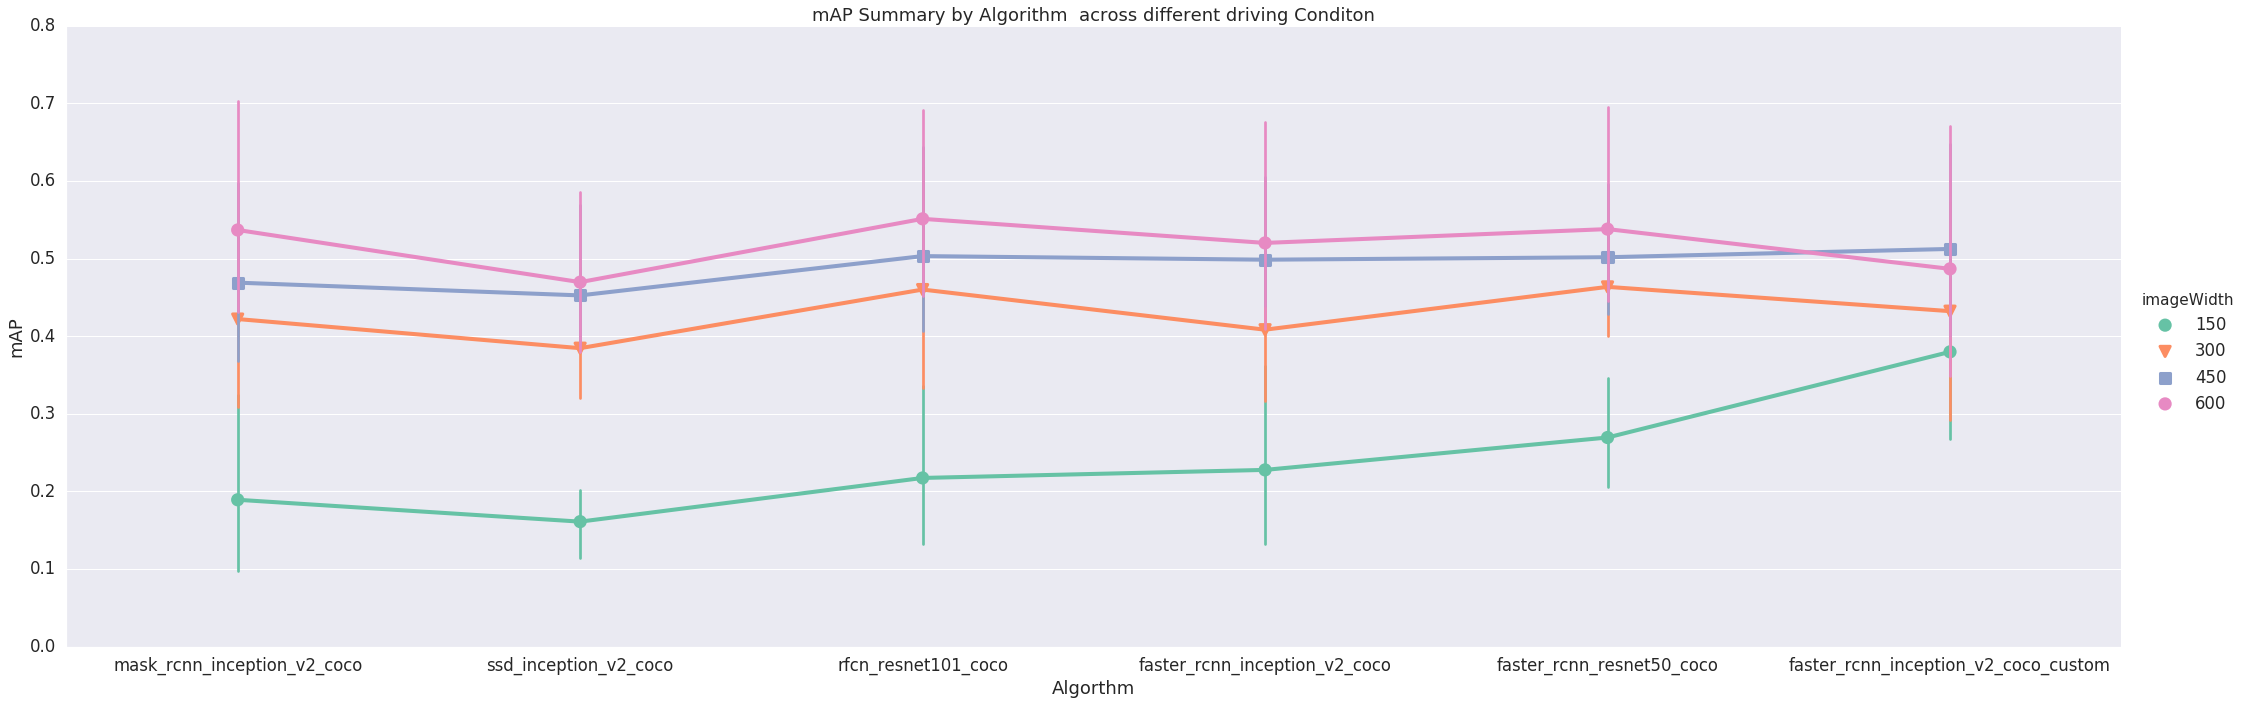

In [29]:
#exercise = sns.load_dataset("exercise")
g = sns.factorplot(x="Algorthm", y="mAP", hue="imageWidth", data=mAP_Summary, ci=95, 
               markers=['o', 'v', 's', 'o', 'v'], scale = 1.5, height=10, aspect=3, palette="Set2")
plt.title('mAP Summary by Algorithm  across different driving Conditon')

/home/kevimwe/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'mAP Summary by Algorithm  across different driving Conditon')

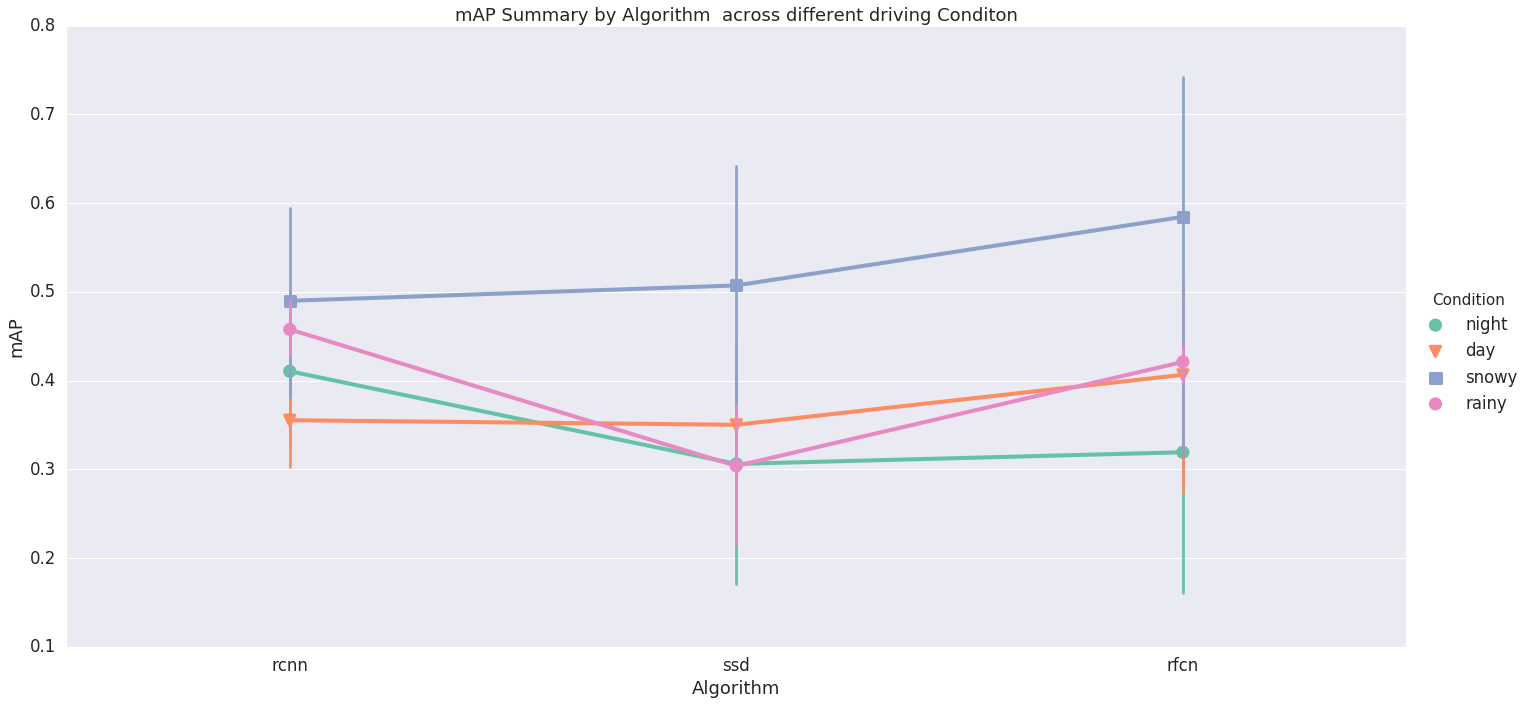

In [30]:
#exercise = sns.load_dataset("exercise")
g = sns.factorplot(x="Algorithm", y="mAP", hue="Condition", data=mAP_Summary, ci=95, 
               markers=['o', 'v', 's', 'o', 'v'], scale = 1.5, height=10, aspect=2, palette="Set2")
plt.title('mAP Summary by Algorithm  across different driving Conditon')

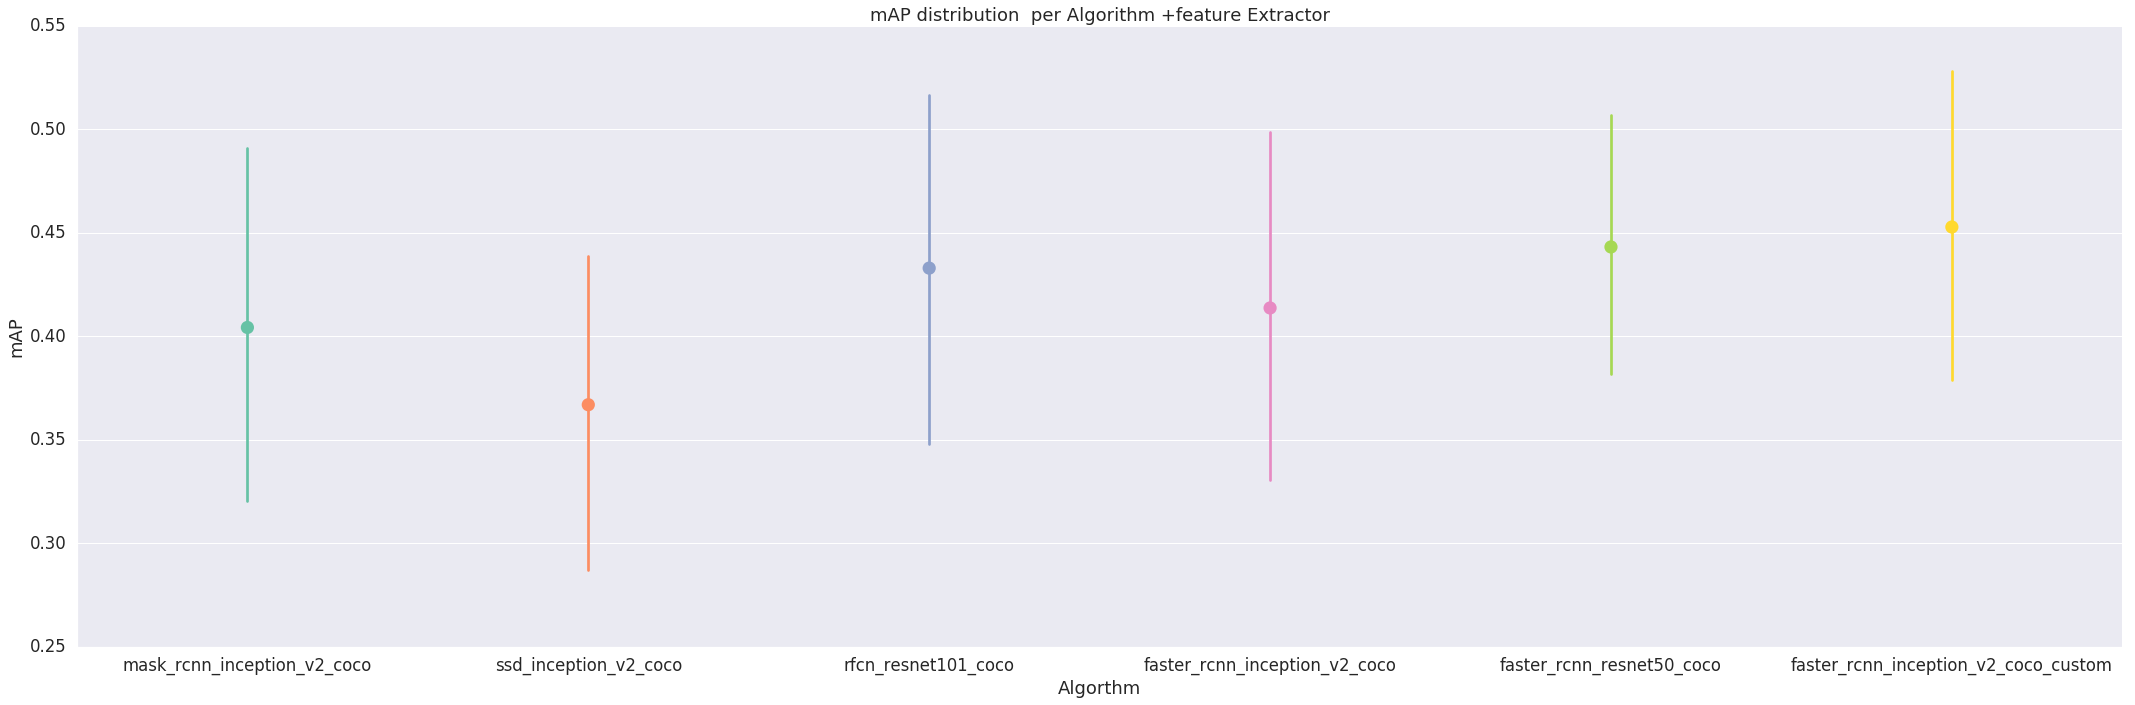

In [31]:
with sns.axes_style("darkgrid"):
    sns.catplot('Algorthm','mAP',data=mAP_Summary, kind="point", height=10, 
                aspect=3, palette="Set2", markers=['o', 'v', 's', 'o', 'v'], scale = 1.5)
    plt.title('mAP distribution  per Algorithm +feature Extractor')

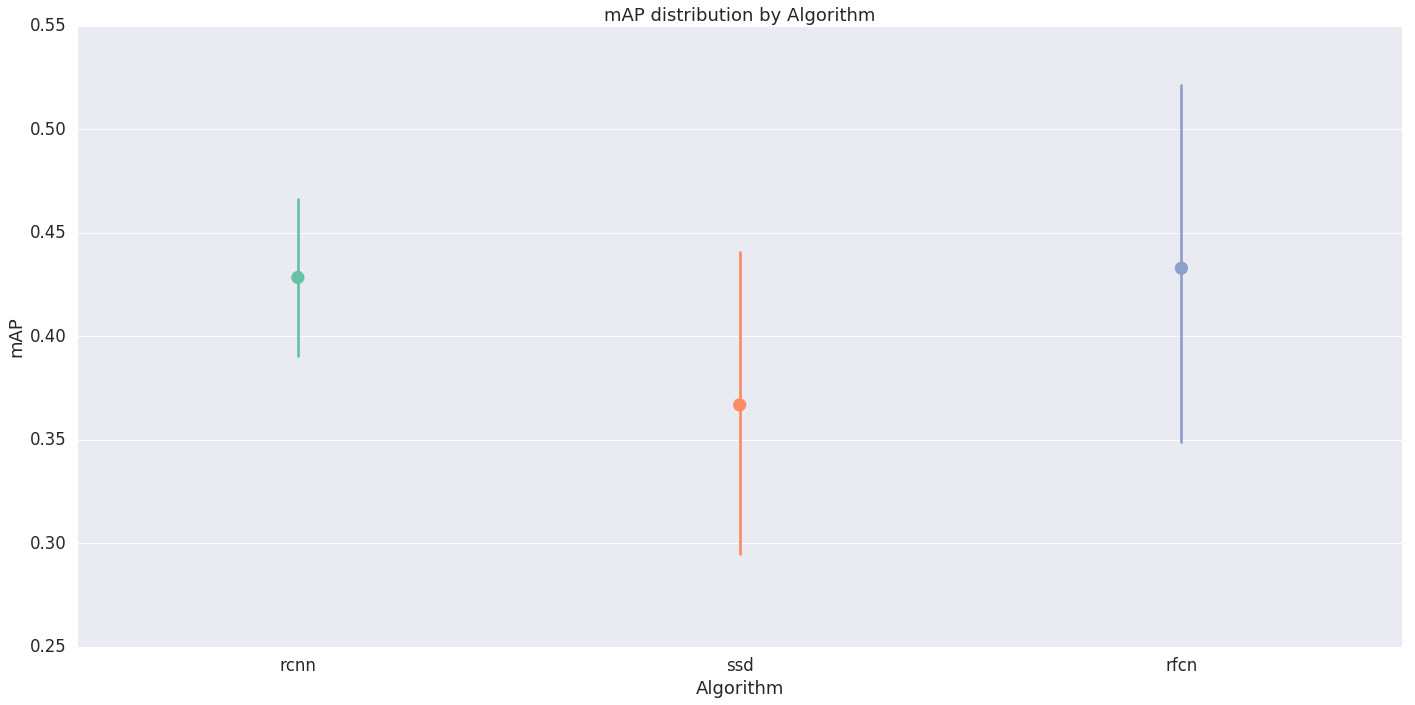

In [32]:
with sns.axes_style("darkgrid"):
    sns.catplot('Algorithm','mAP',data=mAP_Summary, kind="point", height=10, 
                aspect=2, palette="Set2", markers=['o', 'v', 's', 'o', 'v'], scale = 1.5)
    plt.title('mAP distribution by Algorithm')

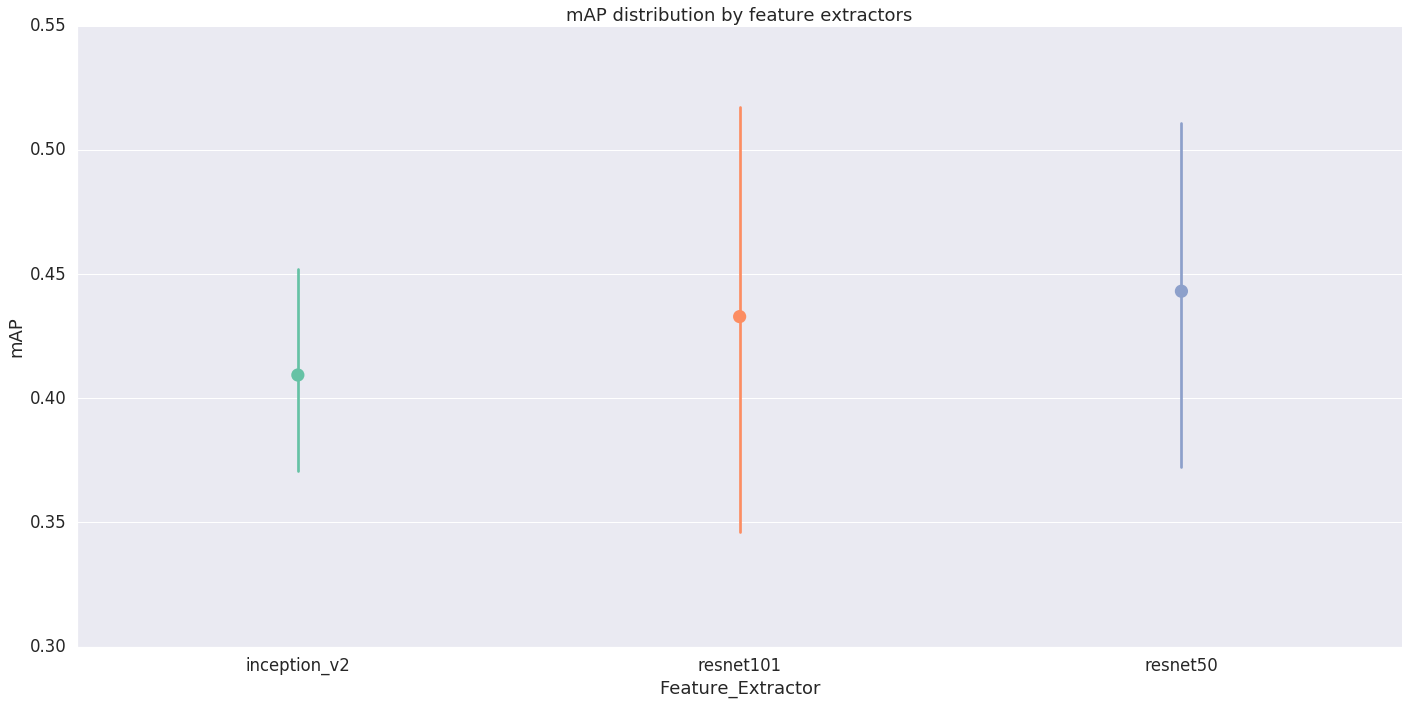

In [33]:
with sns.axes_style("darkgrid"):
    sns.catplot('Feature_Extractor','mAP',data=mAP_Summary, kind="point", height=10, 
                aspect=2, palette="Set2", markers=['o', 'v', 's', 'o', 'v'], scale = 1.5)
    plt.title('mAP distribution by feature extractors')

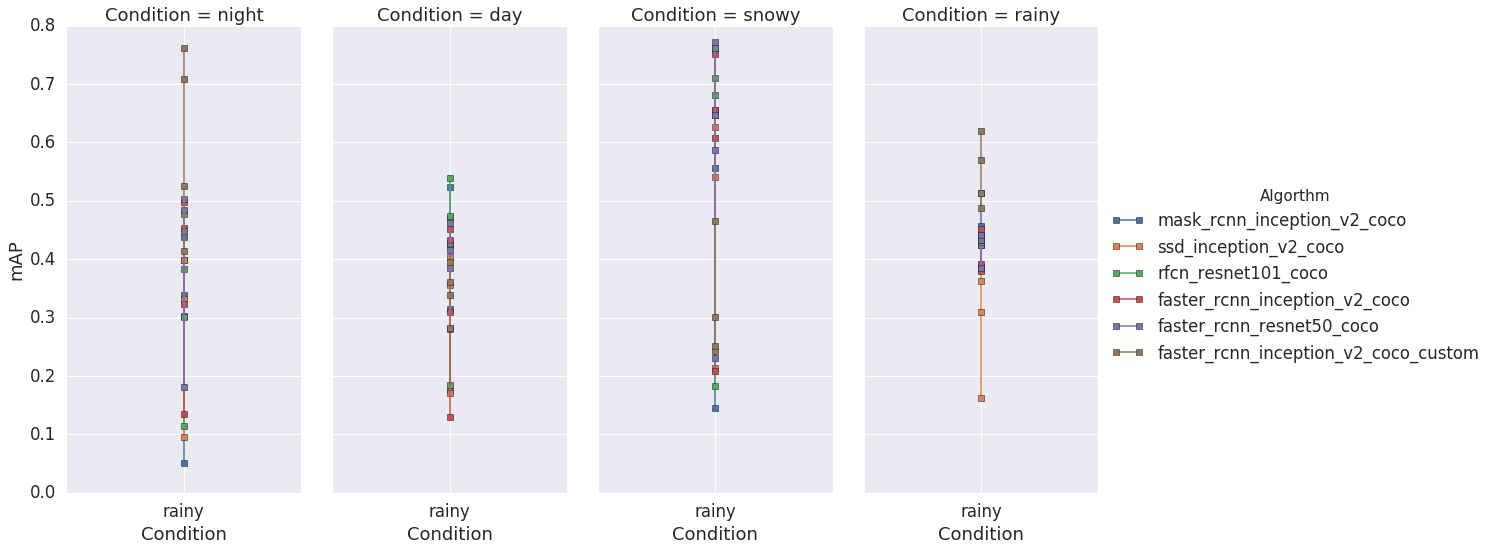

In [38]:
g = sns.FacetGrid(mAP_Summary, col="Condition", col_wrap=4,hue='Algorthm', height=8, aspect=0.5)
g = g.map(plt.plot, 'Condition','mAP', marker="s").add_legend()


### AP for individual classes

In [42]:
pwd

'/home/kevimwe/tensorflow/models/research/object_detection/CapstoneC/samples-1k/Driving_condition/snowy/images/images600'

## Visualize Inference Time Data

In [44]:
temp= pd.DataFrame()
for i in imagesizes: 
    print(i)
    temp = temp.append(pd.read_csv(rootwd+"/InferenceData_"+str(i)+"_scaled.csv"))

150
300
450
600


In [46]:
temp.head()

,Class,Confidence,top,left,bottom,right,Width,Height,Model,Inference Time (Sec),Driving Condition,ImageID,ImageWidth
0,8,0.995397,0.362293,0.109977,0.839752,0.773196,150,112,faster_rcnn_inception_v2_coco_custom,1.354489,day,000000154000_reSized.jpg,150
1,8,0.987935,0.360631,0.331123,0.868939,0.819403,150,112,faster_rcnn_inception_v2_coco_custom,1.354489,day,000000154000_reSized.jpg,150
2,8,0.789560,0.561882,0.644394,0.718899,0.886092,150,112,faster_rcnn_inception_v2_coco_custom,1.354489,day,000000154000_reSized.jpg,150
3,8,0.653652,0.544107,0.343138,0.840966,0.802309,150,112,faster_rcnn_inception_v2_coco_custom,1.354489,day,000000154000_reSized.jpg,150
4,3,0.613290,0.407543,0.181609,0.590846,0.407153,150,112,faster_rcnn_inception_v2_coco_custom,1.354489,day,000000154000_reSized.jpg,150


In [54]:
## Summary Statistics
grouped =temp.groupby(['Model', 'Driving Condition', 'ImageWidth'], as_index=False).agg({"Inference Time (Sec)": [min,max,'mean']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped

,Model_,Driving Condition_,ImageWidth_,Inference Time (Sec)_min,Inference Time (Sec)_max,Inference Time (Sec)_mean
0,faster_rcnn_inception_v2_coco,day,150,3.234475,3.395251,3.290278
1,faster_rcnn_inception_v2_coco,day,300,3.217562,3.352892,3.272966
2,faster_rcnn_inception_v2_coco,day,450,3.186387,3.291679,3.240407
3,faster_rcnn_inception_v2_coco,day,600,3.209133,3.276079,3.244651
4,faster_rcnn_inception_v2_coco,night,150,3.252706,3.535214,3.319887
5,faster_rcnn_inception_v2_coco,night,300,3.204318,3.409658,3.282007
6,faster_rcnn_inception_v2_coco,night,450,3.200113,3.326895,3.248414
7,faster_rcnn_inception_v2_coco,night,600,3.225297,3.314246,3.263926
8,faster_rcnn_inception_v2_coco,rainy,150,3.255345,3.382137,3.300161
9,faster_rcnn_inception_v2_coco,rainy,300,3.229551,3.303005,3.247078


Text(0.5, 1.0, 'Model Inference Time Comparison')

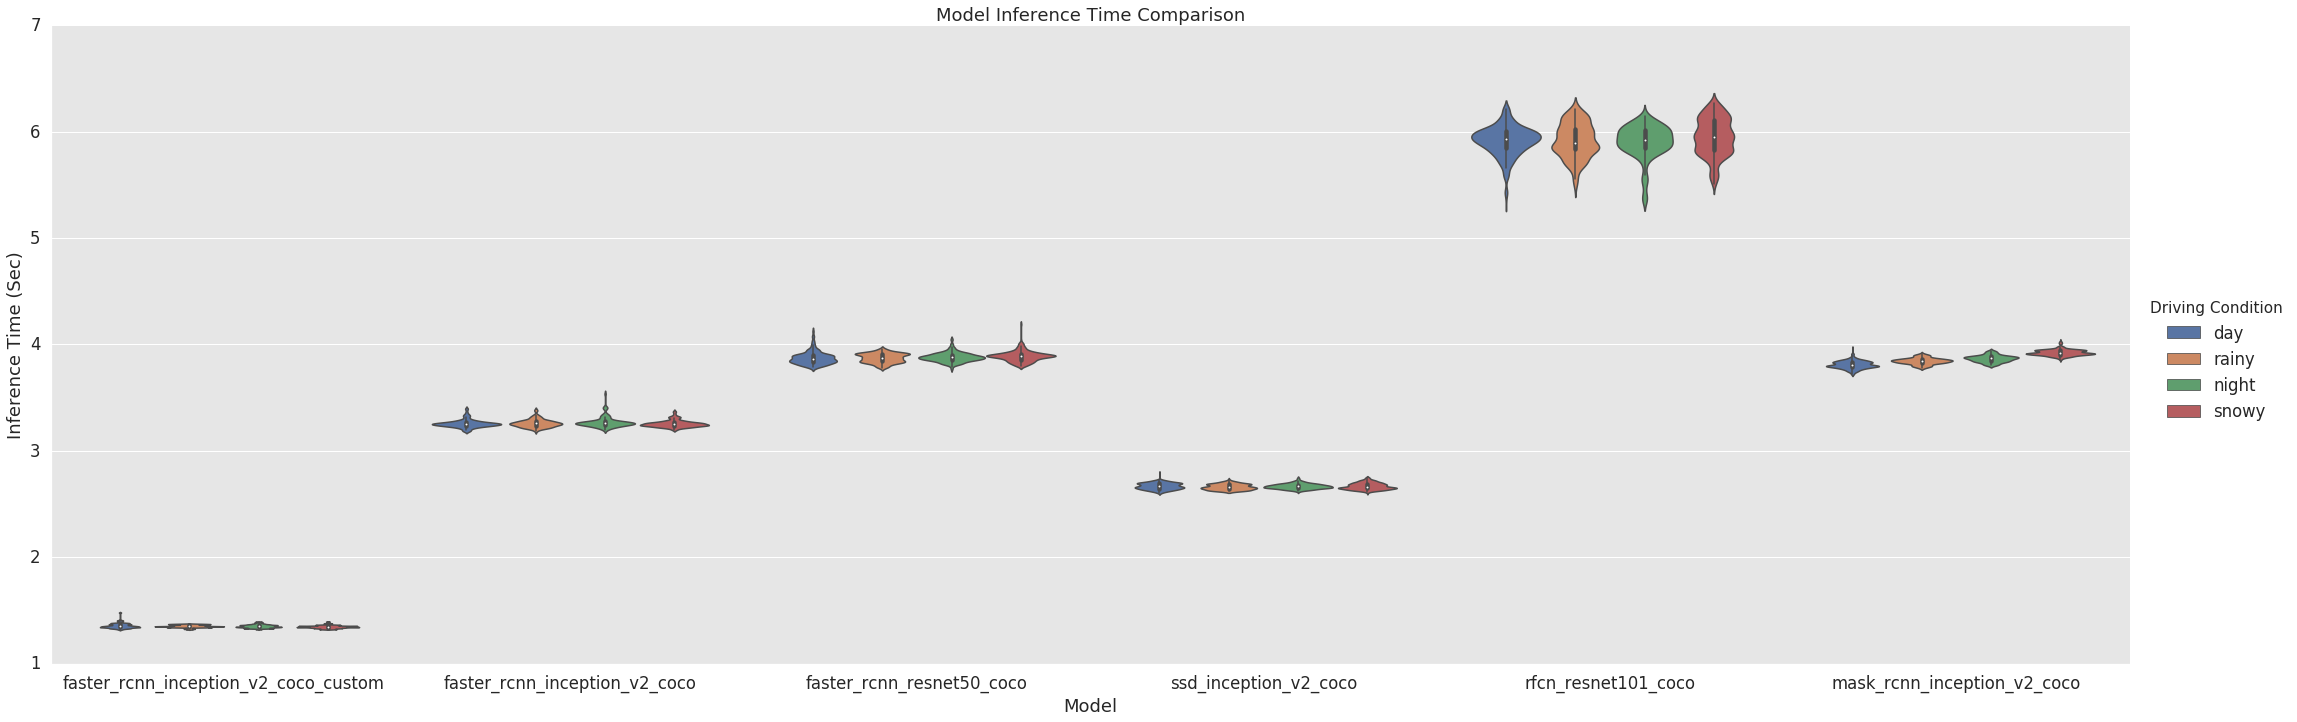

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
df = temp.copy()
g = sns.catplot(x="Model", y="Inference Time (Sec)",
               hue="Driving Condition",# row="Driving Condition",
               data=df, kind="violin",
               height=10, aspect=3)
plt.title("Model Inference Time Comparison")

### Joint Visualizations

In [56]:
grouped.columns = ['Algorthm', 'Condition','ImageWidth', 'Inference Time (Sec)_min','Inference Time (Sec)_max','Inference Time (Sec)_mean']

In [57]:
mAP_Summary=mAP_Summary.reset_index()

In [58]:
mAP_Summary

,level_0,index,Algorthm,mAP,Condition,imageWidth,Algorithm,Feature_Extractor
0,0,51,mask_rcnn_inception_v2_coco,0.050362,night,150,rcnn,inception_v2
1,1,53,ssd_inception_v2_coco,0.095890,night,150,ssd,inception_v2
2,2,52,rfcn_resnet101_coco,0.114106,night,150,rfcn,resnet101
3,3,1,faster_rcnn_inception_v2_coco,0.130057,day,150,rcnn,inception_v2
4,4,49,faster_rcnn_inception_v2_coco,0.134182,night,150,rcnn,inception_v2
5,5,75,mask_rcnn_inception_v2_coco,0.144535,snowy,150,rcnn,inception_v2
6,6,29,ssd_inception_v2_coco,0.162653,rainy,150,ssd,inception_v2
7,7,5,ssd_inception_v2_coco,0.170831,day,150,ssd,inception_v2
8,8,3,mask_rcnn_inception_v2_coco,0.176690,day,150,rcnn,inception_v2
9,9,50,faster_rcnn_resnet50_coco,0.181735,night,150,rcnn,resnet50


In [59]:
result = pd.merge(mAP_Summary, grouped, on=['Algorthm','Condition'])

In [60]:
result

,level_0,index,Algorthm,mAP,Condition,imageWidth,Algorithm,Feature_Extractor,ImageWidth,Inference Time (Sec)_min,Inference Time (Sec)_max,Inference Time (Sec)_mean
0,0,51,mask_rcnn_inception_v2_coco,0.050362,night,150,rcnn,inception_v2,150,3.836567,3.934781,3.875234
1,0,51,mask_rcnn_inception_v2_coco,0.050362,night,150,rcnn,inception_v2,300,3.809503,3.939768,3.861423
2,0,51,mask_rcnn_inception_v2_coco,0.050362,night,150,rcnn,inception_v2,450,3.803805,3.920136,3.864294
3,0,51,mask_rcnn_inception_v2_coco,0.050362,night,150,rcnn,inception_v2,600,3.837439,3.933921,3.874452
4,21,57,mask_rcnn_inception_v2_coco,0.303291,night,300,rcnn,inception_v2,150,3.836567,3.934781,3.875234
5,21,57,mask_rcnn_inception_v2_coco,0.303291,night,300,rcnn,inception_v2,300,3.809503,3.939768,3.861423
6,21,57,mask_rcnn_inception_v2_coco,0.303291,night,300,rcnn,inception_v2,450,3.803805,3.920136,3.864294
7,21,57,mask_rcnn_inception_v2_coco,0.303291,night,300,rcnn,inception_v2,600,3.837439,3.933921,3.874452
8,27,63,mask_rcnn_inception_v2_coco,0.338462,night,450,rcnn,inception_v2,150,3.836567,3.934781,3.875234
9,27,63,mask_rcnn_inception_v2_coco,0.338462,night,450,rcnn,inception_v2,300,3.809503,3.939768,3.861423


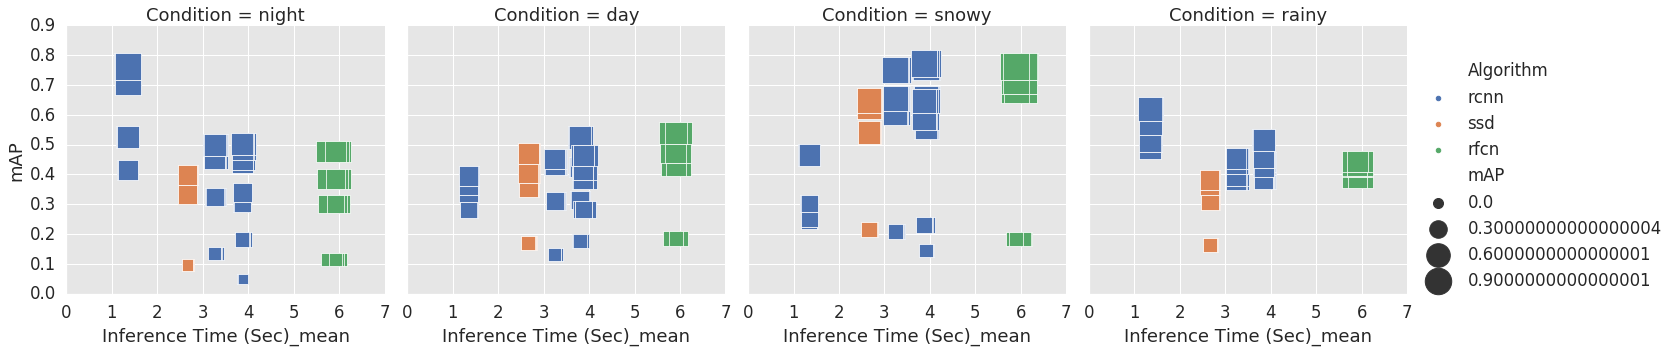

In [74]:
#dat = result[result.ImageWidth==300]

g = sns.relplot(x="Inference Time (Sec)_mean", y="mAP", data=result,height=5, aspect=1,
                hue="Algorithm", size="mAP",sizes=(100, 700), col="Condition",marker="s")

###   Berkeley Dataset download

http://dl.yf.io/bdd-data/v1/videos/

import zipfile, urllib.request, shutil

url = 'http://dl.yf.io/bdd-data/v1/videos/val.zip'
file_name = 'val.zip'

with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)


In [ ]:
with zipfile.ZipFile(file_name) as zf:
    zf.extractall()